# Detection & Analysis of Pre-SN Outburst Simulations

We use our script `simulation_detection.py` to add Gaussian outburst simulations to control light curve flux and determine whether our bump detection algorithm successfully detects these simulations. We determine efficiencies for different Gaussian simulation kernel sizes and peak magnitudes, as well as different algorithm kernel sizes.

Each simulation is recorded and saved into a table corresponding to its peak magnitude. In this notebook, we can load these tables and calculate efficiencies for the previously mentioned parameters by counting the number of successful and failed detections. We additionally calculate contamination for our detection limits using control light curve flux.

All light curves used for the bump analysis must be binned. We use our download script `download_atlas_lc.py` to query ATLAS machines for SN and control light curves; and our cleaning script `clean_atlas_lc.py` to clean and average them. Please refer to the documentation and scripts on GitHub to do so.

In [1]:
##### LOADING THE BINNED SN LIGHT CURVE #####

# Enter the target SN name:
tnsname = '2023ixf'

# Enter the path to the data directory that contains the SN directory:
data_dir = f'.' 

# Enter the path to the directory that contains the simulation detection tables:
tables_dir = f'{data_dir}/{tnsname}/bump_analysis/tables'

# Enter the path to a directory to optionally save any plots:
plots_dir = f'{data_dir}/{tnsname}/bump_analysis/plots'

# Enter the filter for this binned light curve (must be 'o' or 'c'):
filt = 'o'

# Enter the MJD bin size for the binned light curve (should be in file name):
mjd_bin_size = 1.0 

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS using the API key, TNS ID, and bot name):
discovery_date = 60063.727257
api_key = None
tns_id = None
bot_name = None

##### LOADING BINNED CONTROL LIGHT CURVES #####

# Set to True if you are planning on applying the control light curve cut 
# and have already downloaded the control light curves:
load_controls = True

# Enter the number of control light curves to load:
n_controls = 16 #8

# Enter the source directory of the control light curve files:
controls_dir = f'{data_dir}/{tnsname}/controls'

## Miscellaneous functions (skip this section)

In [2]:
import sys
sys.path.insert(1,'../')
import pandas as pd
import numpy as np
import copy,math,os
from scipy import interpolate
from pdastro import pdastrostatsclass
from atlas_lc import atlas_lc
from simulation_detection import AandB, AnotB, SimDetecLightCurve, EfficiencyTable, Gaussian, Eruption, flux2mag, mag2flux, load_sd_dict, get_valid_ix

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# 'Mask' column flags
flags = {'chisquare':0x1, 
         'uncertainty':0x2,
         'controls_bad':0x400000,
         'avg_badday':0x800000}

# default plotting styles
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 11)
plt.rc('ytick', labelsize = 11)
plt.rc('legend', fontsize = 9)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1.5
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1.5
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.linewidth'] = 1.5
marker_size = 20
marker_edgewidth = 1.5
simbump_ls = 'dashed'
fomlimit_ls = 'dotted'
# plotting color scheme
facecolor = 'whitesmoke'
# flux
sn_flux = 'orange'
sn_flagged_flux = 'red'
#ctrl_flux = 'limegreen'
select_ctrl_flux = 'forestgreen' #'darkgreen'
# FOM
sn_fom = 'deeppink'#'magenta'
ctrl_fom = 'cornflowerblue'
select_ctrl_fom = 'mediumblue'
colors = ['indianred', 'salmon', 'sandybrown', 'gold', 'yellowgreen', 'mediumseagreen', 'turquoise', 'lightskyblue', 'plum', 'palevioletred']
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=colors)

# suppress matplotlib warnings
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")

def save_plot(save_filename=None):
    if not save_filename is None:
        filename = f'{plots_dir}/{save_filename}.png'
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        print(f'Saving plot: {filename}')
        plt.savefig(filename, dpi=200, bbox_inches='tight')

def plot_all_fom(lc, select_index, sigma_kerns, all_fom_dict, skip_control_ix=[], all_fom_limits=None, mjd_ranges=None, all_ylims=None, fom_hist_max=5000, save_filename='all_foms', save=False):
    fig, axes = plt.subplots(len(sigma_kerns), 2, gridspec_kw={'width_ratios': [4, 1]})
    fig.set_figheight(len(sigma_kerns)*1.9)
    fig.set_figwidth(5.5)
    fig.subplots_adjust(wspace=0.07, hspace=0.07, bottom=0.1, top=0.9)

    for i, row in enumerate(axes):
        sigma_kern = sigma_kerns[i]
        all_fom = all_fom_dict[sigma_kern]
        
        if len(sigma_kerns) == 1:
            ax1, ax2 = axes[0], axes[1]
        else:
            ax1, ax2 = axes[i][0], axes[i][1]
        ax1.minorticks_on()
        ax1.tick_params(direction='in', which='both')
        ax1.set_facecolor(facecolor)
        ax2.minorticks_on()
        ax2.tick_params(direction='in', which='both')
        ax2.set_facecolor(facecolor)
        if i < len(sigma_kerns) - 1: # all but bottom row
            ax1.set_xticklabels([])
            ax2.set_xticklabels([])
        else: # bottom row
            ax1.set_xlabel('MJD')
            ax2.set_xlabel('Freq')

        preSN_ix = lc.get_pre_SN_ix(colname='MJDbin')
        lc.apply_rolling_sum(0, sigma_kern, indices=preSN_ix)
        lc.apply_rolling_sums(sigma_kern)
    
        if not all_fom_limits is None:
            fom_limits = all_fom_limits[sigma_kern]
            for fom_limit in fom_limits:
                ax1.axhline(fom_limit, linewidth=1.5, color='k', linestyle=fomlimit_ls, zorder=40) 
                ax2.axhline(fom_limit, linewidth=1.5, color='k', linestyle=fomlimit_ls, zorder=40) 
                ax1.text(0.07, fom_limit, r'$\Sigma_{\rm FOM, limit}$ = '+str(fom_limit), color="k", transform=ax1.get_yaxis_transform(), ha="left", va="bottom") 

        if all_ylims is None:
            if all_fom_limits is None:
                ax1.set_ylim(min(all_fom)*1.5, max(all_fom)*1.8)
            else:
                ax1.set_ylim(min(all_fom)*1.5, max(max(all_fom)*1.8, fom_limits[-1]*1.3))
        else: 
            ax1.set_ylim(all_ylims[sigma_kern][0], all_ylims[sigma_kern][1]) 

        ax1.text(.98, .07, r'$\sigma_{\rm kernel}$ = '+str(sigma_kern), 
                 ha='right', va='bottom', transform=ax1.transAxes, fontsize=11)
        ax1.set_ylabel(r'$\Sigma_{\rm FOM}$')
        ax1.axhline(color='k', zorder=0)
        ax1.set_xlim(mjd_ranges[0][0]-20, min(mjd_ranges[-1][1]+20, lc.discdate))
        # control lcs fom
        for control_index in range(1, lc.num_controls):
            if control_index in skip_control_ix or control_index == select_index:
                continue
            ax1.plot(lc.lcs[control_index].t['MJDbin'], lc.lcs[control_index].t['SNRsumnorm'], color=ctrl_fom, alpha=0.3, zorder=10)
        ax1.plot([0,1],[0,0], color=ctrl_fom, linewidth=1.5,  alpha=0.6, zorder=0, label=f'{lc.num_controls-len(skip_control_ix)-1} Control Light Curves')
        # selected control lc fom
        ax1.plot(lc.lcs[select_index].t['MJDbin'], lc.lcs[select_index].t['SNRsumnorm'], color=select_ctrl_fom, linewidth=1.5, alpha=0.7, zorder=20, label=f'Selected Control Light Curve #{select_index}')
        # pre-SN lc fom
        ax1.plot(lc.lcs[0].t['MJDbin'], lc.lcs[0].t['SNRsumnorm'], color=sn_fom, linewidth=1.5, label='Pre-SN Light Curve', zorder=30)

        ax2.set_yticklabels([])
        ylim_lower, ylim_upper = ax1.get_ylim()
        ax2.set_ylim(ylim_lower, ylim_upper)
        ax2.set_xlim(0, fom_hist_max) # TODO: FIX ME
        ax2.hist(all_fom, bins=20, orientation="horizontal", color=ctrl_fom)

        if i == 0:
            ax1.legend(facecolor='white', fontsize=10, framealpha=0, bbox_to_anchor=(0, 1.3, 0.8, 0.2), loc="upper center", mode="expand", borderaxespad=0, ncol=1)

        if len(sigma_kerns) == 1:
            break

    if save:
        save_plot(save_filename=save_filename)

def plot_preSN_lcs(og_lc, lc, ylims=None, plot_mjd_ranges=False, mjd_ranges=None, save=False):
    fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
    #fig.set_figwidth(7)
    #fig.set_figheight(3)
    fig.set_figwidth(4)
    fig.set_figheight(3.5)

    ax1.set_facecolor(facecolor)
    ax2.set_facecolor(facecolor)

    # original lc 
    
    if not ylims is None:
        ax1.set_ylim(ylims[0], ylims[1])
    ax1.set_xlim(og_lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax1.minorticks_on()
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.axhline(linewidth=1.5, color='k', zorder=0)
    ax1.text(.06, .94, f'Pre-SN Light Curve', ha='left', va='top', transform=ax1.transAxes, fontsize=11, zorder=100).set_bbox(dict(facecolor=facecolor, alpha=0.8, edgecolor='silver'))

    good_ix = og_lc.get_unmasked_ix(flags)
    bad_ix = AnotB(og_lc.get_ix(),good_ix)

    # cleaned
    ax1.errorbar(og_lc.lcs[0].t.loc[good_ix,'MJD'], og_lc.lcs[0].t.loc[good_ix,'uJy'], yerr=og_lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=0)
    ax1.scatter(og_lc.lcs[0].t.loc[good_ix,'MJD'], og_lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Measurements', zorder=0)

    # flagged
    ax1.errorbar(og_lc.lcs[0].t.loc[bad_ix,'MJD'], og_lc.lcs[0].t.loc[bad_ix,'uJy'], yerr=og_lc.lcs[0].t.loc[bad_ix,'duJy'], fmt='none', ecolor=sn_flagged_flux, elinewidth=1.5, capsize=1.2, c=sn_flagged_flux, alpha=0.5, zorder=10)
    ax1.scatter(og_lc.lcs[0].t.loc[bad_ix,'MJD'], og_lc.lcs[0].t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, facecolors='none', edgecolors=sn_flagged_flux, marker='o', alpha=0.5, label=f'Flagged Measurements', zorder=10)

    # averaged lc

    #ax2.set_ylim(ylims[0], ylims[1])
    ax2.set_ylim(-200, 200)
    ax2.set_xlim(og_lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(r'Flux ($\mu$Jy)')
    ax2.set_xlabel('MJD')
    ax2.axhline(linewidth=1.5, color='k', zorder=0)
    ax2.text(.06, .94, f'Binned Pre-SN Light Curve', ha='left', va='top', transform=ax2.transAxes, fontsize=11, zorder=100).set_bbox(dict(facecolor=facecolor, alpha=0.8, edgecolor='silver'))

    good_ix = lc.get_unmasked_ix(flags) 
    bad_ix = AnotB(lc.get_ix(),good_ix)

    # cleaned
    ax2.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=0)
    ax2.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Measurements', zorder=0)

    # flagged
    ax2.errorbar(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], yerr=lc.lcs[0].t.loc[bad_ix,'duJy'], fmt='none', ecolor=sn_flagged_flux, elinewidth=1.5, capsize=1.2, c=sn_flagged_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, facecolors='none', edgecolors=sn_flagged_flux, marker='o', alpha=0.5, label=f'Flagged Measurements', zorder=10)

    if plot_mjd_ranges and not mjd_ranges is None:
        # valid mjd ranges
        for mjd_range in mjd_ranges:
            ax1.axvline(mjd_range[0], color='k', linestyle='dashed', zorder=100)
            ax1.axvline(mjd_range[1], color='k', linestyle='dashed', zorder=100)
            ax2.axvline(mjd_range[0], color='k', linestyle='dashed', zorder=100)
            ax2.axvline(mjd_range[1], color='k', linestyle='dashed', zorder=100)

    #ax1.legend(facecolor='white', fontsize=10, framealpha=0, bbox_to_anchor=(0, 1.15, 0.8, 0.2), loc="upper center", mode="expand", borderaxespad=0, ncol=1)
    ax2.legend(facecolor='white', edgecolor='silver', fontsize=9, framealpha=0.8, handletextpad=0.1, loc="lower right", borderaxespad=1, ncol=1).set_zorder(100)

    if save:
        save_plot(save_filename=f'cleaned_avg')

def plot_control_lcs1(lc, xlims=None, ylims=None, save=False):
    fig, axes = plt.subplots(lc.num_controls, constrained_layout=True)
    fig.set_figheight(lc.num_controls)
    fig.set_figwidth(5)

    for i in range(lc.num_controls):
        control_index = i + 1
        axes[i].minorticks_on()
        axes[i].tick_params(direction='in', which='both')
        axes[i].set_facecolor(facecolor)

        if i < lc.num_controls-1: 
            axes[i].set_xticklabels([])
        else:
            axes[i].set_xlabel('MJD')

        axes[i].set_ylabel(r'Flux ($\mu$Jy)')

        if not ylims is None:
            axes[i].set_ylim(ylims[0], ylims[1])
        if not xlims is None:
            axes[i].set_xlim(xlims[0], xlims[1])

        axes[i].axhline(linewidth=1.5, color='k', zorder=0)

        good_ix = lc.get_unmasked_ix(flags, control_index=control_index) 
        axes[i].errorbar(lc.lcs[control_index].t.loc[good_ix,'MJD'], lc.lcs[control_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[control_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
        axes[i].scatter(lc.lcs[control_index].t.loc[good_ix,'MJD'], lc.lcs[control_index].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=10)

        if i == 0:
            text = f'Binned & Cleaned Control Light Curve #{control_index}'
        else:
            text = f'#{control_index}'
        axes[i].text(.02, .95, text, ha='left', va='top', transform=axes[i].transAxes, fontsize=11, zorder=20)

    if save:
        save_plot(save_filename=f'controls')

def plot_control_lcs2(lc, xlims=None, ylims=None, save=False):
    assert lc.num_controls % 2 == 0
    
    n_rows = int(lc.num_controls/2)
    fig, axes = plt.subplots(n_rows, 2, constrained_layout=True)
    fig.set_figheight(n_rows*1.2)
    fig.set_figwidth(7)

    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            control_index = j*(lc.num_controls/2) + i + 1
            
            if j == 0: # left column
                ax.set_ylabel(r'Flux (µJy)')
            else:
                ax.set_yticklabels([])
            
            if i == n_rows - 1: # bottom row
                ax.set_xlabel('MJD')
            else:
                ax.set_xticklabels([])
                
            if control_index == 1:
                text = f'Binned & Cleaned Control Light Curve #{int(control_index)}'
            else:
                text = f'#{int(control_index)}'
            ax.text(.04, .95, text, ha='left', va='top', transform=ax.transAxes, fontsize=11, zorder=20)

            ax.tick_params(which='both', direction='in')
            ax.minorticks_on()
            ax.set_facecolor(facecolor)
            ax.axhline(color='k', zorder=0)
            if not ylims is None:
                ax.set_ylim(ylims[0], ylims[1])
            if not xlims is None:
                ax.set_xlim(xlims[0], xlims[1])

            good_ix = lc.get_unmasked_ix(flags, control_index=control_index) 
            ax.errorbar(lc.lcs[control_index].t.loc[good_ix,'MJD'], lc.lcs[control_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[control_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
            ax.scatter(lc.lcs[control_index].t.loc[good_ix,'MJD'], lc.lcs[control_index].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=10)

            #good_ix = lc.get_unmasked_ix(flags, control_index=control_index) 
            #ax.errorbar(lc.lcs[control_index].t['MJD'], lc.lcs[control_index].t['uJy'], yerr=lc.lcs[control_index].t['duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
            #ax.scatter(lc.lcs[control_index].t['MJD'], lc.lcs[control_index].t['uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=10)


    if save:
        save_plot(save_filename=f'controls')

def plot_control_lcs(lc, xlims=None, ylims=None, save=False, twocolumns=False):
    if twocolumns:
        if lc.num_controls % 2 != 0:
            raise RuntimeError(f'ERROR: number of control light curves ({lc.num_controls}) must be even; set twocolumns=False for one column')
        plot_control_lcs2(lc, xlims=xlims, ylims=ylims, save=save)
    else:
        plot_control_lcs1(lc, xlims=xlims, ylims=ylims, save=save)

def plot_preSN_control_lcs(lc, select_index, ylims=None, save=False):
    fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
    #fig.set_figwidth(7)
    #fig.set_figheight(3)
    fig.set_figwidth(4)
    fig.set_figheight(3.5)

    ax1.set_ylim(ylims[0], ylims[1])
    ax1.set_xlim(lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax1.minorticks_on()
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in', which='both')
    ax1.set_facecolor(facecolor)
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.axhline(linewidth=1.5, color='k', zorder=0)
    ax1.text(.04, .95, f'Binned & Cleaned Pre-SN Light Curve', 
          ha='left', va='top', transform=ax1.transAxes, fontsize=11, zorder=100)

    # pre-SN lc flux
    good_ix = lc.get_unmasked_ix(flags) 
    ax1.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=20)
    ax1.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Pre-SN Light Curve', zorder=20)

    ax2.set_ylim(ylims[0], ylims[1])
    ax2.set_xlim(lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_facecolor(facecolor)
    ax2.set_ylabel(r'Flux ($\mu$Jy)')
    ax2.set_xlabel('MJD')
    ax2.axhline(linewidth=1.5, color='k', zorder=0)
    ax2.text(.04, .95, f'Binned & Cleaned Control Light Curve #{select_index}', 
          ha='left', va='top', transform=ax2.transAxes, fontsize=11, zorder=100)

    # control lc flux
    good_ix = lc.get_unmasked_ix(flags, control_index=select_index) 
    ax2.errorbar(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[select_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, label=f'Cleaned Control Light Curve #{select_index}', zorder=10)

    if save:
        save_plot(save_filename=f'avg_control')

def plot_fom_dists(sigma_kerns, all_fom_dict, all_fom_limits, xlims=None, save=False, save_filename='fom_hists'):
    n = len(sigma_kerns)
    fig, axes = plt.subplots(n, constrained_layout=True)
    fig.set_figheight(n)
    fig.set_figwidth(5)

    if xlims is None:
        xlim_lower = np.inf
        xlim_upper = -np.inf
        for sigma_kern in sigma_kerns:
            max_fom = max(max(all_fom_dict[sigma_kern]), all_fom_limits[sigma_kern][-1])
            min_fom = min(all_fom_dict[sigma_kern])
            xlim_upper = max_fom if max_fom > xlim_upper else xlim_upper
            xlim_lower = min_fom if min_fom < xlim_lower else xlim_lower

    for i in range(n):
        sigma_kern = sigma_kerns[i]
        all_fom = all_fom_dict[sigma_kern]
        fom_limits = all_fom_limits[sigma_kern]

        axes[i].minorticks_on()
        axes[i].tick_params(direction='in', which='both')
        axes[i].set_facecolor(facecolor)
        if i < n-1: 
            axes[i].set_xticklabels([])
        else:
            axes[i].set_xlabel(r'$\Sigma_{\rm FOM}$')
        
        if xlims is None:
            axes[i].set_xlim(xlim_lower-1, xlim_upper+120)
        else:
            axes[i].set_xlim(xlims[0], xlims[1])

        bins = np.linspace(min(all_fom), max(all_fom), 20)

        axes[i].text(.02, .95, r'$\sigma_{\rm kernel}$ = '+str(sigma_kern), 
                    ha='left', va='top', transform=axes[i].transAxes, fontsize=11)
        axes[i].hist(all_fom, bins=bins, color=ctrl_fom)

        ylim_upper = axes[i].get_ylim()[1]
        if len(fom_limits) > 1:
            axes[i].axvline(fom_limits[0], linewidth=1.5, color='k', linestyle=fomlimit_ls)#, label=r'$\Sigma_{\rm FOM, limit} (3\sigma)$ = '+f'{fom_limits[0]:0.2f}') 
            axes[i].text(fom_limits[0]+1, 0.75*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[0]:0.2f}', fontsize=11)
            axes[i].axvline(fom_limits[1], linewidth=1.5, color='k', linestyle=fomlimit_ls)#, label=r'$\Sigma_{\rm FOM, limit} (5\sigma)$ = '+f'{fom_limits[1]:0.2f}') 
            axes[i].text(fom_limits[1]+1, 0.4*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[1]:0.2f}', fontsize=11)
        else:
            axes[i].axvline(fom_limits[0], linewidth=1.5, color='k', linestyle=fomlimit_ls)
            axes[i].text(fom_limits[0]+1, 0.75*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[0]:0.2f}', fontsize=11)

    if save:
        save_plot(save_filename=f'{save_filename}')

def plot_excluded_MJD_ranges(lc, select_index, mjd_ranges_exclude, ylims=(-150, 200), save=False):
    fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
    fig.set_figwidth(4)
    fig.set_figheight(3.5)

    ax1.set_ylim(ylims[0], ylims[1])
    ax1.set_xlim(lc.lcs[0].t.loc[0,'MJDbin'],lc.lcs[0].t.loc[len(lc.lcs[0].t)-1,'MJDbin'])
    ax1.minorticks_on()
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in', which='both')
    ax1.set_facecolor(facecolor)
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.axhline(linewidth=1.5, color='k', zorder=0)
    ax1.text(.04, .95, f'Binned & Cleaned Pre-SN Light Curve', 
          ha='left', va='top', transform=ax1.transAxes, fontsize=11, zorder=100)

    # pre-SN lc flux
    good_ix = lc.get_unmasked_ix(flags) 
    ax1.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=20)
    ax1.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Pre-SN Light Curve', zorder=20)

    ax2.set_ylim(ylims[0], ylims[1])
    xlim_lower, xlim_upper = ax1.get_xlim()
    ax2.set_xlim(xlim_lower,xlim_upper)
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_facecolor(facecolor)
    ax2.set_ylabel(r'Flux ($\mu$Jy)')
    ax2.set_xlabel('MJD')
    ax2.axhline(linewidth=1.5, color='k', zorder=0)
    ax2.text(.04, .95, f'Binned & Cleaned Control Light Curve #{select_index}', 
          ha='left', va='top', transform=ax2.transAxes, fontsize=11, zorder=100)

    # control lc flux
    good_ix = lc.get_unmasked_ix(flags, control_index=select_index) 
    ax2.errorbar(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[select_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, label=f'Cleaned Control Light Curve #{select_index}', zorder=10)

    for i in range(len(mjd_ranges_exclude)):
        for ax in [ax1, ax2]:
            ax.axvspan(mjd_ranges_exclude[i][0], mjd_ranges_exclude[i][1], color='red', alpha=0.2, zorder=0)

    if save:
        save_plot(save_filename=f'mjd_ranges')

def plot_efficiency(e, sigma_kern, save=False):
    fig, ax1 = plt.subplots(1, constrained_layout=True)
    fig.set_figheight(2.5)
    fig.set_figwidth(4.5)

    assert len(e.fom_limits[sigma_kern]) == 1
    fom_limit = e.fom_limits[sigma_kern][0]
    
    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_facecolor(facecolor)
    #ax1.text(.03, .05, r'$\sigma_{\rm kern}$ = '+f'{sigma_kern} days, \n'+r'$\Sigma_{\rm FOM,limit} = $'+f'{fom_limit:0.2f}',
    #		ha='left', va='bottom', transform=ax1.transAxes, fontsize=11)
    ax1.text(.03, .05, r'$\sigma_{\rm kernel}$ = '+f'{sigma_kern}',ha='left', va='bottom', transform=ax1.transAxes, fontsize=11)
    ax1.set_xlabel(r'$m_{peak}$ (app mag)')
    ax1.set_ylabel(f'Efficiency (%)')

    if e.sigma_sims[sigma_kern][0] == 2:
        color_offset = 0
    elif e.sigma_sims[sigma_kern][0] == 5:
        color_offset = 1
    elif e.sigma_sims[sigma_kern][0] == 20:
        color_offset = 2
    else:
        raise RuntimeError('ERROR: not enough colors for sigma_sims')
    
    ax1.axhline(80, color='k', linestyle='dashed', linewidth=1.0)
    ax1.axhline(50, color='k', linestyle='dashed', linewidth=1.0)

    for i in range(len(e.sigma_sims[sigma_kern])):
        color = colors[i+color_offset]
        sigma_sim = e.sigma_sims[sigma_kern][i]
        subset = e.get_subset(sigma_kern=sigma_kern, sigma_sim=sigma_sim, fom_limit=fom_limit)
        label = r'$\sigma_{\rm sim} = $'+f'{sigma_sim}'
        ax1.scatter(subset['peak_appmag'], subset[f'pct_detec_{fom_limit:0.2f}'], color=color, edgecolors='none', marker='o', label=label, s=15, zorder=-i*20)
        ax1.plot(subset['peak_appmag'], subset[f'pct_detec_{fom_limit:0.2f}'], color=color, zorder=-i*10)

    ax1.legend(loc='upper left', facecolor='white', fontsize=9, framealpha=0, handletextpad=0.1, bbox_to_anchor=(0.98, 1.06)).set_zorder(100)

    # abs mag
    ax2 = ax1.twiny()
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_facecolor(facecolor)
    ax2.set_xticklabels([round(x-29.04) for x in ax1.get_xticks()])
    ax2.set_xlabel("$m_{peak}$ (abs mag)")

    if save:
        save_plot(save_filename=f'efficiency_{sigma_kern}')
        
def plot_mag_thresholds(e, mt, ylims=None, log=False, base=10, save=False, save_filename='mag_thresholds'):
    fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout=True)
    fig.set_figwidth(2.5)
    fig.set_figheight(3.7)
    
    if not ylims is None:
        ax1.set_ylim(ylims[0],ylims[1])
        ax2.set_ylim(ylims[0],ylims[1])

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_facecolor(facecolor)
    ax1.set_ylabel(r'$m_{threshold}$ (mag)')
    ax1.text(.97, .08, f'for 50% efficiency', ha='right', va='bottom', transform=ax1.transAxes, fontsize=11)
        
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_facecolor(facecolor)
    ax2.set_xlabel(r'$\sigma_{\rm sim}$ (days)')
    ax2.set_ylabel(r'$m_{threshold}$ (mag)')
    #ax2.text(.07, .96, f'for 80% efficiency', ha='left', va='top', transform=ax2.transAxes, fontsize=11)
    ax2.text(.97, .08, f'for 80% efficiency', ha='right', va='bottom', transform=ax2.transAxes, fontsize=11)

    for i in range(len(e.sigma_kerns)):
        sigma_kern = e.sigma_kerns[i] 
        sigma_kern_ix = mt[mt['sigma_kern'] == sigma_kern].index
        assert len(e.fom_limits[sigma_kern]) == 1

        for ax, percent_efficiency in zip([ax1, ax2], [50, 80]):
            label = r'$\sigma_{\rm kernel}$'+f' = {sigma_kern}'
            if percent_efficiency == 80:
                label = None
            ax.scatter(mt.loc[sigma_kern_ix,'sigma_sim'], mt.loc[sigma_kern_ix,f'mag_threshold_{percent_efficiency}'], s=15, color=colors[i+1], marker='o', label=label, zorder=-i*10)
            if log:
                ax.semilogx(mt.loc[sigma_kern_ix,'sigma_sim'], mt.loc[sigma_kern_ix,f'mag_threshold_{percent_efficiency}'], color=colors[i+1], zorder=-i*10, base=base)
            else:
                ax.plot(mt.loc[sigma_kern_ix,'sigma_sim'], mt.loc[sigma_kern_ix,f'mag_threshold_{percent_efficiency}'], color=colors[i+1], zorder=-i*10)

    if log:
        ax1.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
        ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    else:
        ax1.set_xticklabels([])
    fig.legend(facecolor='white', framealpha=0, bbox_to_anchor=(0.97, 0.8), handletextpad=0.1, loc='upper left')#, ncol=2)

    if save:
        save_plot(save_filename=f'{save_filename}')

## Load the binned ATLAS light curve

In [3]:
print(f'SN {tnsname}, filter {filt}, MJD bin size {mjd_bin_size} day(s), {n_controls} control light curves')
if not discovery_date is None:
    print(f'SN discovery date: {discovery_date}')
print(f'\nData directory (contains all SN directories): \t{data_dir}')
print(f'SN directory (load SN light curves): \t\t{data_dir}/{tnsname}')
if load_controls: 
    print(f'Controls directory (load control light curves): {controls_dir}')
print(f'Simulation detection tables directory: \t\t{tables_dir}')
print(f'Directory for saving plots: \t\t\t{plots_dir}')

SN 2023ixf, filter o, MJD bin size 1.0 day(s), 16 control light curves
SN discovery date: 60063.727257

Data directory (contains all SN directories): 	.
SN directory (load SN light curves): 		./2023ixf
Controls directory (load control light curves): ./2023ixf/controls
Simulation detection tables directory: 		./2023ixf/bump_analysis/tables
Directory for saving plots: 			./2023ixf/bump_analysis/plots


In [4]:
if filt != 'o' and filt != 'c': 
	raise RuntimeError('Filter must be "o" or "c"!')

# load cleaned light curve
og_lc = atlas_lc(tnsname=tnsname, discdate=discovery_date)
# load binned light curve
lc = SimDetecLightCurve(filt, mjd_bin_size, tnsname=tnsname, discdate=discovery_date)

# get discovery date
if lc.discdate is None:
	lc._get_tns_data(tnsname, api_key, tns_id, bot_name)
	og_lc.set_tns_data(lc.ra, lc.dec, lc.discdate)
	
# load cleaned SN and control light curves
og_lc._load(data_dir, filt, 0)

# load binned SN and control light curves
lc.load(data_dir, num_controls=n_controls)


Loading SN light curve and 0 control light curves...

Loading averaged SN light curve and 16 averaged control light curves...


### Plot cleaned original and binned pre-SN light curves

In [5]:
# Enter observation seasons as a series of MJD ranges: 
mjd_ranges = [[57365,57622],
              [57762,57983], 
              [58120,58383], 
              [58494,58741], 
              [58822,59093],
              [59184,59445], 
              [59566,59835], 
              [59901,60182]]

# Plot MJD ranges (observation seasons)?:
plot_mjd_ranges = False

# Enter plot y limits (set to None for automatic):
ylims = (-300, 300)

# Save plot?:
save = True

Saving plot: ./2023ixf/bump_analysis/plots/cleaned_avg.png


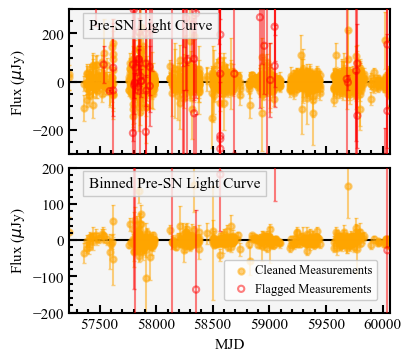

In [6]:
plot_preSN_lcs(og_lc, lc, ylims=ylims, plot_mjd_ranges=plot_mjd_ranges, mjd_ranges=mjd_ranges, save=save)

### Plot all control light curves

In [7]:
# Enter plot x limits (set to None for automatic):
xlims = None 

# Enter plot y limits (set to None for automatic):
ylims = (-200,200) 

# Save plot?:
save = True

Saving plot: ./2023ixf/bump_analysis/plots/controls.png


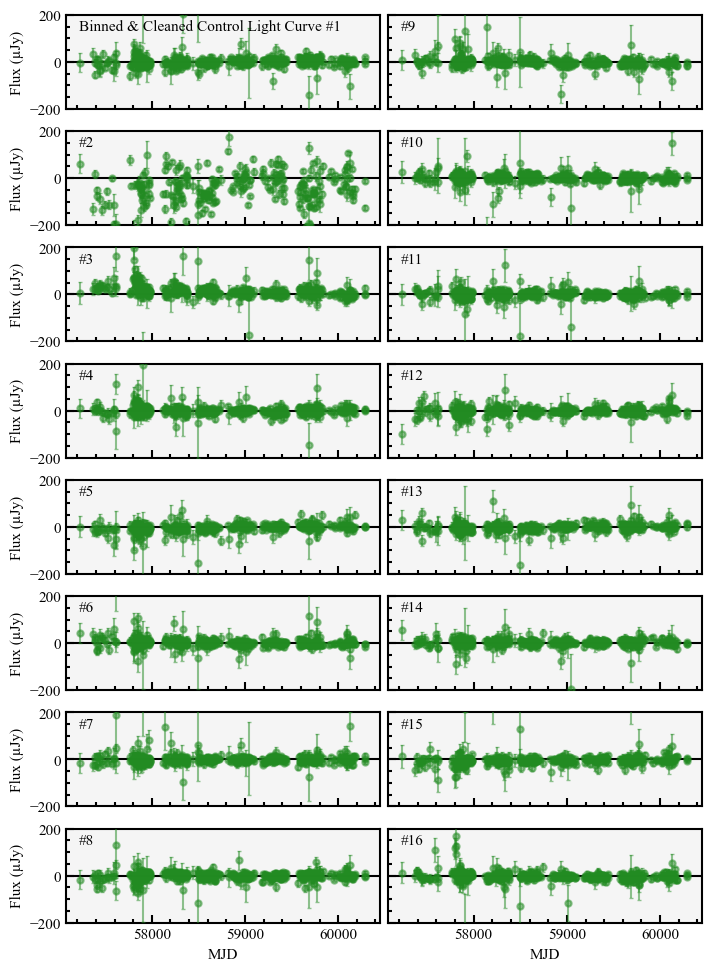

In [8]:
plot_control_lcs(lc, xlims=xlims, ylims=ylims, save=save, twocolumns=True)

### Plot averaged pre-SN and selected control light curve

In [9]:
# Enter the index of the control light curve to plot:
select_index = 7

# Enter plot y limits (set to None for automatic):
ylims = (-150, 200)

# Save plot?:
save = True

Saving plot: ./2023ixf/bump_analysis/plots/avg_control.png


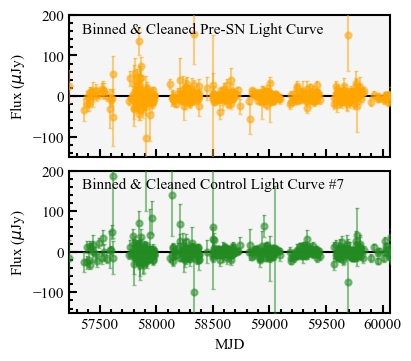

In [10]:
plot_preSN_control_lcs(lc, select_index, ylims=ylims, save=save)

## Get detection limits w.r.t. contamination

We use the bisection method to calculate the best detection limits $\Sigma_{\rm FOM, limit}$ for each $\sigma_{\rm kernel}$ with respect to a target contamination value.

We measure contamination for a given $\sigma_{\rm kernel}$ and its corresponding $\Sigma_{\rm FOM, limit}$ by counting the number of false positives in the control light curves (where a single false positive is defined by a continuous sequence of $\Sigma_{\rm FOM}$ above $\Sigma_{\rm FOM, limit}$). We record two alternative measures of contamination for evaluating a certain $\Sigma_{\rm FOM, limit}$:
1. the number of positive control light curves (default option)
2. the total number of false positives throughout all control light curve

### Exclude bad MJD ranges and determine valid seasons

In [11]:
# Optionally expand observation gap MJD ranges by +-exclude_obs_edges days on either side (set to None or 0 to skip):
exclude_obs_edges = 30

# Optionally exclude additional bad observation seasons or MJD ranges (set to None to skip):
mjd_ranges_remove = [[57233,58119], [59886, 59970]] #, [58701, 58741], [58822, 58849]] #[59901,60182],

In [12]:
def shrink_mjd_ranges_by(mjd_ranges, indices=None, exclude_obs_edges=0):
    if indices is None:
        indices = range(len(mjd_ranges))
    for j in range(len(mjd_ranges)):
        if j in indices:
            mjd_ranges[j][0] += exclude_obs_edges
            mjd_ranges[j][1] -= exclude_obs_edges
    return mjd_ranges

def expand_mjd_ranges_by(mjd_ranges, indices=None, exclude_obs_edges=0):
    if indices is None:
        indices = range(len(mjd_ranges))
    for j in range(len(mjd_ranges)):
        if j in indices:
            mjd_ranges[j][0] -= exclude_obs_edges
            mjd_ranges[j][1] += exclude_obs_edges
    return mjd_ranges

def get_mjd_ranges_inverse(mjd_ranges, debug=False):
    mjd_ranges_new = []
    for i in range(len(mjd_ranges)):
        if debug: print(f'base {mjd_ranges[i]}')
        if len(mjd_ranges) == 1:
            if mjd_ranges[i][0] > min(lc.lcs[0].t['MJDbin'])-0.5:
                if debug: print(f'## 0adding {[round(min(lc.lcs[0].t["MJDbin"])-0.5), mjd_ranges[i][0]]}')
                mjd_ranges_new.append([round(min(lc.lcs[0].t['MJDbin'])-0.5), mjd_ranges[i][0]])
            if debug: print(f'## 0adding {[mjd_ranges[i][1], round(max(lc.lcs[0].t["MJDbin"])+0.5)]}')
            mjd_ranges_new.append([mjd_ranges[i][1], round(max(lc.lcs[0].t['MJDbin'])+0.5)])
        elif i == 0:
            if debug: print(f'## 1adding {[round(min(lc.lcs[0].t["MJDbin"])-0.5), mjd_ranges[i][0]]}')
            mjd_ranges_new.append([round(min(lc.lcs[0].t['MJDbin'])-0.5), mjd_ranges[i][0]])
        elif i == len(mjd_ranges) - 1:
            if debug: print(f'## 2adding {[mjd_ranges[i-1][1], mjd_ranges[i][0]]}')
            mjd_ranges_new.append([mjd_ranges[i-1][1], mjd_ranges[i][0]])
            if debug: print(f'## 2adding {[mjd_ranges[i][1], round(max(lc.lcs[0].t["MJDbin"])+0.5)]}')
            mjd_ranges_new.append([mjd_ranges[i][1], round(max(lc.lcs[0].t['MJDbin'])+0.5)])
        else:
            if debug: print(f'## 3adding {[mjd_ranges[i-1][1], mjd_ranges[i][0]]}')
            mjd_ranges_new.append([mjd_ranges[i-1][1], mjd_ranges[i][0]])
    
    mjd_ranges_new[i][0] += 1
    mjd_ranges_new[i][1] -= 1
    
    return mjd_ranges_new

def remove_mjd_ranges_from(mjd_ranges, mjd_ranges_remove, debug=False):
    if mjd_ranges_remove is None or len(mjd_ranges_remove) < 1:
        return copy.deepcopy(mjd_ranges)
    
    mjd_ranges = [mjd_range for mjd_range in copy.deepcopy(mjd_ranges) if not mjd_range in mjd_ranges_remove]
    if debug: print(f'{mjd_ranges}')

    mjd_ranges_new = []
    for i in range(len(mjd_ranges)):
        base_start = mjd_ranges[i][0]
        base_end = mjd_ranges[i][1]
        appended = False
        for remove_start, remove_end in mjd_ranges_remove:
            if debug: print(f'# base [{base_start},{base_end}], remove [{remove_start},{remove_end}]')
            if remove_start <= base_start and remove_end >= base_end:
                if debug: print(f'## 0skipping {mjd_ranges[i]}')
                appended = True
                break
            elif remove_start > base_start and remove_end < base_end:
                if debug: print(f'## 1adding {[mjd_ranges[i][0], remove_start-1]}, {[remove_end+1, base_end]}')
                mjd_ranges_new.append([mjd_ranges[i][0], remove_start - 1])
                mjd_ranges_new.append([remove_end+1, base_end])
                appended = True
            elif base_start <= remove_start <= base_end or base_start <= remove_end <= base_end:
                if remove_start > base_start:
                    if debug: print(f'## 2adding {[mjd_ranges[i][0], remove_start-1]}')
                    mjd_ranges_new.append([mjd_ranges[i][0], remove_start-1])
                    appended = True
                elif remove_end < base_end:
                    if debug: print(f'## 3adding {[remove_end+1, mjd_ranges[i][1]]}')
                    mjd_ranges_new.append([remove_end+1, mjd_ranges[i][1]])
                    appended = True

        if not appended: 
            mjd_ranges_new.append(mjd_ranges[i])
    
    return mjd_ranges_new

def add_mjd_ranges_to(mjd_ranges, mjd_ranges_add):
    return get_mjd_ranges_inverse(remove_mjd_ranges_from(mjd_ranges, mjd_ranges_add))

def get_included_mjd_ranges(mjd_ranges, mjd_ranges_remove, debug=False):
    return remove_mjd_ranges_from(mjd_ranges, mjd_ranges_remove, debug=debug)

def get_excluded_mjd_ranges(mjd_ranges_include, debug=False):
    return get_mjd_ranges_inverse(mjd_ranges_include, debug=debug)

print(f'Observation season MJD ranges: \n\t{mjd_ranges}')
print(f'Excluding observation gaps AND these additional MJD ranges from main analysis: \n\t{mjd_ranges_remove}')
if exclude_obs_edges is None:
    exclude_obs_edges = 0
print(f'Expanding observation gap MJD ranges by {exclude_obs_edges} days on either side')

mjd_ranges_include = get_included_mjd_ranges(mjd_ranges, mjd_ranges_remove)
mjd_ranges_exclude = get_excluded_mjd_ranges(mjd_ranges_include)
mjd_ranges_exclude = expand_mjd_ranges_by(mjd_ranges_exclude, indices=[0, 2, 3, 5, 6], exclude_obs_edges=exclude_obs_edges)
print(f'Excluded MJD ranges: \n\t{mjd_ranges_exclude}')
mjd_ranges_include = get_mjd_ranges_inverse(mjd_ranges_exclude)[1:-1]
print(f'Included MJD ranges: \n\t{mjd_ranges_include}')

Observation season MJD ranges: 
	[[57365, 57622], [57762, 57983], [58120, 58383], [58494, 58741], [58822, 59093], [59184, 59445], [59566, 59835], [59901, 60182]]
Excluding observation gaps AND these additional MJD ranges from main analysis: 
	[[57233, 58119], [59886, 59970]]
Expanding observation gap MJD ranges by 30 days on either side
Excluded MJD ranges: 
	[[57203, 58150], [58383, 58494], [58711, 58852], [59063, 59214], [59445, 59566], [59806, 60000], [60152, 60325]]
Included MJD ranges: 
	[[58150, 58383], [58494, 58711], [58852, 59063], [59214, 59445], [59566, 59806], [60001, 60151]]


In [13]:
include_ix = get_valid_ix(lc.lcs[0].t, 'MJD', mjd_ranges_include)
print('Averaged light curve num included measurements: ',len(include_ix))
exclude_ix = get_valid_ix(lc.lcs[0].t, 'MJD', mjd_ranges_exclude)
print('Averaged light curve num excluded measurements: ',len(exclude_ix))
nan_ix = np.where(pd.isnull(lc.lcs[0].t['MJD']))[0]
print('Averaged light curve num NaN MJD: ',len(nan_ix))
print('Averaged light curve total measurements: ',len(lc.lcs[0].t), len(include_ix)+len(exclude_ix)+len(nan_ix))
print(f'Averaged light curve percent included measurements: {100*len(include_ix)/(len(lc.lcs[0].t)-len(nan_ix)):0.2f}%')

include_ix = get_valid_ix(og_lc.lcs[0].t, 'MJD', mjd_ranges_include)
print('\nOriginal light curve num included measurements: ',len(include_ix))
exclude_ix = get_valid_ix(og_lc.lcs[0].t, 'MJD', mjd_ranges_exclude)
print('Original light curve num excluded measurements: ',len(exclude_ix))
nan_ix = np.where(pd.isnull(og_lc.lcs[0].t['MJD']))[0]
print('Original light curve num NaN MJD: ',len(nan_ix))
print('Original light curve total measurements: ',len(og_lc.lcs[0].t), len(include_ix)+len(exclude_ix)+len(nan_ix))
print(f'Original light curve percent included measurements: {100*len(include_ix)/len(og_lc.lcs[0].t):0.2f}%')

Averaged light curve num included measurements:  318
Averaged light curve num excluded measurements:  144
Averaged light curve num NaN MJD:  2600
Averaged light curve total measurements:  3062 3062
Averaged light curve percent included measurements: 68.83%

Original light curve num included measurements:  1306
Original light curve num excluded measurements:  632
Original light curve num NaN MJD:  0
Original light curve total measurements:  1938 1938
Original light curve percent included measurements: 67.39%


#### Plot: excluded MJD ranges

In [14]:
# Enter plot y limits (set to None for automatic):
ylims = (-150, 200)

# Plot excluded MJD ranges?
plot = True

# Save plot?:
save = True

Saving plot: ./2023ixf/bump_analysis/plots/mjd_ranges.png


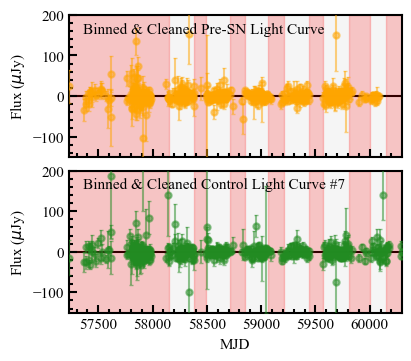

In [15]:
if plot:
    plot_excluded_MJD_ranges(lc, select_index, mjd_ranges_exclude, ylims=ylims, save=save)

### Calculate the preliminary range of valid detection limits $\Sigma_{\rm FOM, limit}$

As our starting range of valid detection limits $\Sigma_{\rm FOM, limit}$, we set our lower limit to 0 and our upper limit to the maximum $\Sigma_{\rm FOM}$ value across all control light curves.

In [16]:
# Exclude certain control lcs from the analysis 
# (set to empty list [] for no exclusions):
skip_control_ix = [2, 3]

# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]

In [17]:
def get_all_fom_dict(lc, sigma_kerns, skip_control_ix, mjd_ranges):
    all_fom_dict = { sigma_kern: None for sigma_kern in sigma_kerns } 
    print(f'\nGetting all FOM for MJD ranges {mjd_ranges}...')
    for i in range(len(sigma_kerns)):
        sigma_kern = sigma_kerns[i]
        allfom = pd.Series()
        for control_index in range(1, lc.num_controls+1):
            if control_index in skip_control_ix:
                continue
            lc.apply_rolling_sum(control_index, sigma_kern)
            ix = lc.get_valid_ix(control_index, mjd_ranges)
            allfom = pd.concat([allfom, lc.lcs[control_index].t.loc[ix,'SNRsumnorm']], ignore_index=True)
        all_fom_dict[sigma_kern] = allfom
    return all_fom_dict

def get_fom_limit_range(sigma_kerns, all_fom_dict):
    print('Getting preliminary valid FOM limit range...')
    prelim_fomlim_range = {sigma_kern: [0] for sigma_kern in sigma_kerns}
    for sigma_kern in sigma_kerns:
        all_fom = all_fom_dict[sigma_kern]
        max_fom = round(max(all_fom)+0.01,2)
        prelim_fomlim_range[sigma_kern].append(max_fom)
    print(f'Valid FOM limit range: {prelim_fomlim_range}')
    return prelim_fomlim_range

print(f'Excluding control light curve indices {skip_control_ix} from analysis')

all_fom_dict = get_all_fom_dict(lc, sigma_kerns, skip_control_ix, mjd_ranges_include)
fom_limit_range = get_fom_limit_range(sigma_kerns, all_fom_dict)

Excluding control light curve indices [2, 3] from analysis

Getting all FOM for MJD ranges [[58150, 58383], [58494, 58711], [58852, 59063], [59214, 59445], [59566, 59806], [60001, 60151]]...
Getting preliminary valid FOM limit range...
Valid FOM limit range: {5: [0, 9.98], 15: [0, 12.57], 25: [0, 16.48], 40: [0, 18.07], 80: [0, 25.51], 130: [0, 30.14], 200: [0, 45.4], 300: [0, 64.42]}


In [18]:
def get_n_falsepos(lc, control_index, sigma_kern, fom_limit, mjd_ranges, verbose=False):
    valid_ix = lc.get_valid_ix(control_index, mjd_ranges)
    if control_index == 0:
        preSN_ix = lc.get_pre_SN_ix(colname='MJDbin')
        valid_ix = AandB(preSN_ix, valid_ix)
        lc.apply_rolling_sum(0, sigma_kern, indices=preSN_ix)
    else:
        lc.apply_rolling_sum(control_index, sigma_kern)

    # find any triggers above the fom limit
    count = 0
    mjds = []
    above_lim = False
    for k in valid_ix: 
        if lc.lcs[control_index].t.loc[k, 'SNRsumnorm'] > fom_limit:
            if not above_lim: 
                mjd = lc.lcs[control_index].t.loc[k, "MJDbin"]
                if control_index > 0: # control lc
                    mjds.append(mjd)
                    count += 1
                elif mjd < discovery_date: # MJD must be in pre-SN lc
                    mjds.append(mjd)
                    count += 1
            above_lim = True
        else:
            above_lim = False
    
    if verbose and len(mjds) > 0:
        print(f'sigma_kern {sigma_kern}, FOM limit {fom_limit:0.2f}, control index {control_index}: {count} trigger(s) at MJDs {mjds}')
    return count

def get_contamination(lc, sigma_kern, fom_limit, mjd_ranges, skip_control_ix, verbose=False):
    row = {
        'sigma_kern': sigma_kern,
        'fom_limit': fom_limit,
        'n_falsepos': 0,
        'n_pos_controls': 0,
        'pct_pos_controls': np.nan,
    }

    for control_index in range(lc.num_controls+1):
        if control_index in skip_control_ix:
            continue

        n_falsepos = get_n_falsepos(lc, control_index, sigma_kern, fom_limit, mjd_ranges, verbose=verbose)
        row[f'n_falsepos_{control_index:02d}'] = n_falsepos

        if control_index > 0 and n_falsepos > 0:
            row['n_pos_controls'] += 1
            row['n_falsepos'] += n_falsepos

    row['pct_pos_controls'] = round(100 * row['n_pos_controls'] / (lc.num_controls-len(skip_control_ix)), 2)
    return row

def get_contamination_table(lc, sigma_kerns, all_fom_limits, mjd_ranges, skip_control_ix, verbose=False, save_filename='contamination', save=False):
    contam = pd.DataFrame()
    for sigma_kern in sigma_kerns:
        for fom_limit in all_fom_limits[sigma_kern]:
            row = get_contamination(lc, sigma_kern, fom_limit, mjd_ranges, skip_control_ix, verbose=verbose)
            contam = pd.concat([contam, pd.DataFrame([row])], ignore_index=True)

    if save:
        contam.to_string(f'{tables_dir}/{save_filename}.txt')
    return contam

print('Calculating preliminary contamination table for included MJD ranges...')
prelim_contam = get_contamination_table(lc, sigma_kerns, fom_limit_range, mjd_ranges_include, skip_control_ix)
print(prelim_contam.to_string())

Calculating preliminary contamination table for included MJD ranges...
    sigma_kern  fom_limit  n_falsepos  n_pos_controls  pct_pos_controls  n_falsepos_00  n_falsepos_01  n_falsepos_04  n_falsepos_05  n_falsepos_06  n_falsepos_07  n_falsepos_08  n_falsepos_09  n_falsepos_10  n_falsepos_11  n_falsepos_12  n_falsepos_13  n_falsepos_14  n_falsepos_15  n_falsepos_16
0            5       0.00         327              14            100.00             25             26             26             18             27             28             23             18             24             28             28             23             20             20             18
1            5       9.98           0               0              0.00              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0
2           15       0.00         109 

#### Plot: all pre-SN and control light curve $\Sigma_{\rm FOM}$ for each $\sigma_{\rm kernel}$

In [19]:
# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]

# Plot all control light curve FOM?:
plot = True

# Save plot?:
save = True

Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Saving plot: ./2023ixf/bump_analysis/plots/all_foms_prelim1.png


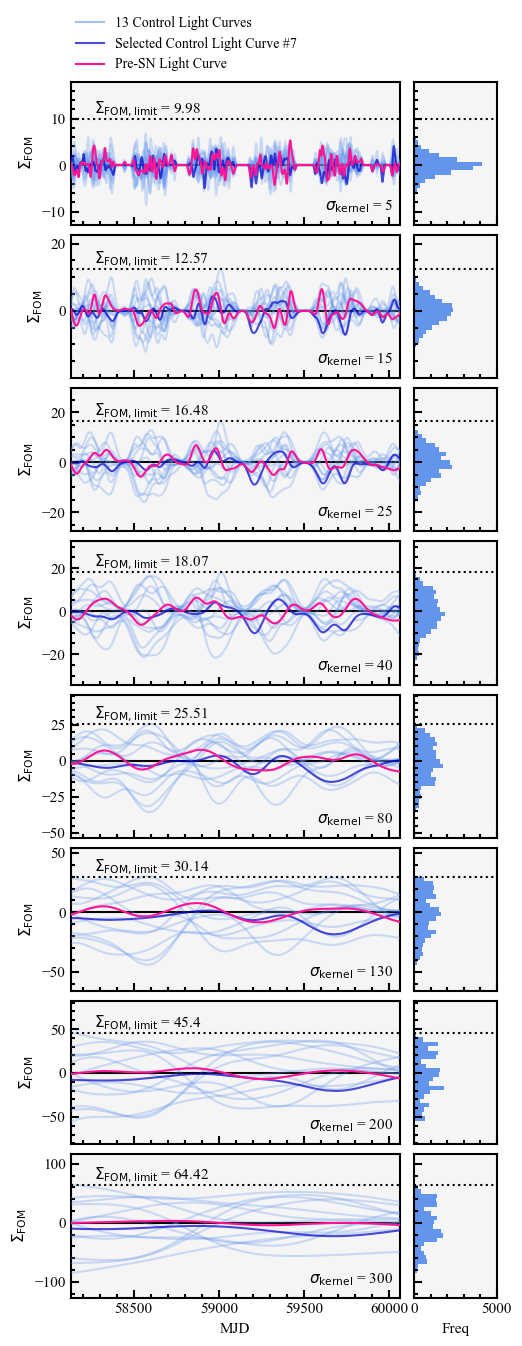

In [20]:
if plot:
    plot_all_fom(lc, select_index,  sigma_kerns, all_fom_dict, skip_control_ix=skip_control_ix, all_fom_limits={sigma_kern:[fom_limit_range[sigma_kern][1]] for sigma_kern in sigma_kerns}, mjd_ranges=mjd_ranges_include, save_filename='all_foms_prelim1', save=save)

In [21]:
# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 40, 80]

# Plot all control light curve FOM?:
plot = True

# Save plot?:
save = True

Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Saving plot: ./2023ixf/bump_analysis/plots/all_foms_prelim2.png


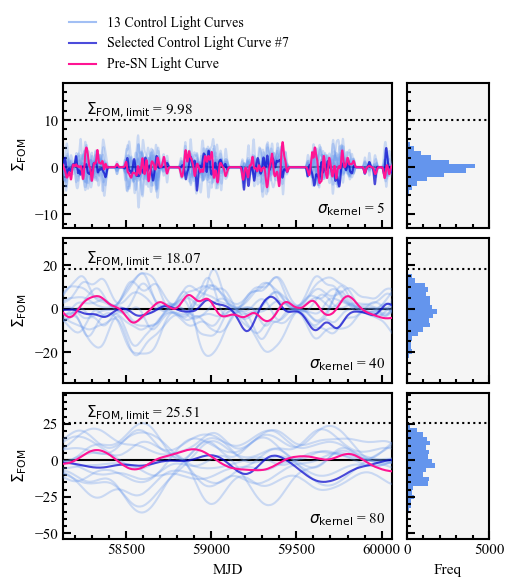

In [22]:
if plot:
    plot_all_fom(lc, select_index, [5, 40, 80], all_fom_dict, skip_control_ix=skip_control_ix, all_fom_limits={sigma_kern:[fom_limit_range[sigma_kern][1]] for sigma_kern in [5, 40, 80]}, mjd_ranges=mjd_ranges_include, save_filename='all_foms_prelim2', save=save)

### Calculate the best detection limits $\Sigma_{\rm FOM, limit}$

We use the starting range of valid detection limits $\Sigma_{\rm FOM, limit}$ and their corresponding contamination values to calculate the detection limit with the ideal contamination. Below, we allow the user to select the desired measure of contamination (`n_pos_controls` for the number of positive control light curves, or `n_falsepos` for the number of total false positives throughout all control light curves) in the `tgt_colname` field, as well as the desired value in the `tgt_value` field. 

We iterate for `n_steps` steps. If we have a starting range of detection limits $\Sigma_{\rm FOM, limit}$ from $a$ to $b$ and iterate for $n$ steps, we obtain the detection limit with the desired contamination with an accuracy of $\frac{b-a}{2^n}$.

In [ ]:
# Enter the column name of the measure you want to use to represent contamination
# (must be 'n_pos_controls' or 'n_falsepos'):
tgt_colname = 'n_pos_controls'

# Enter the target value for that measure:
tgt_value = 2

# Enter the number of steps/iterations for each sigma_kern: 
n_steps = 15

# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]

# load contamination tables
load = True
load_filename = 'contamination_include' # for included seasons

# Save new contamination table to tables_dir?:
save = True
save_filename = 'contamination_include' # for included seasons

In [24]:
def get_fom_limits(fom_limit_range, prelim_contam, mjd_ranges, tgt_colname='n_pos_controls', tgt_value=1, n_steps=8, verbose=False):
    print(f'Calculating new FOM limits...')
    if not isinstance(tgt_value, int):
        raise RuntimeError(f'ERROR: Target value tgt_value={tgt_value} must be an integer!')
    print(f'Target column name: {tgt_colname}\nTarget value: {tgt_value}\nNumber of steps: {n_steps}')

    contam = copy.deepcopy(prelim_contam)
    print(f'Starting FOM limits: {fom_limit_range}')
    if verbose:
        print('Starting contamination table:\n',contam.to_string())

    all_fom_limits = {}
    i = 0
    while i < len(contam) - 1:
        sigma_kern = contam.loc[i,'sigma_kern']
        lower_limit = round(contam.loc[i,'fom_limit'],2)
        upper_limit = round(contam.loc[i+1,'fom_limit'],2)
        assert lower_limit == fom_limit_range[sigma_kern][0] and upper_limit == fom_limit_range[sigma_kern][1]

        if verbose:
            print(f'# sigma_kern={sigma_kern}, lower_limit={lower_limit}, upper_limit={upper_limit}')

        for _ in range(n_steps):
            new_fom_limit = round((upper_limit + lower_limit)/2, 2)
            new_row = get_contamination(lc, sigma_kern, new_fom_limit, mjd_ranges, skip_control_ix)
            cur_value = new_row[tgt_colname]
            contam.loc[i+1,:] = new_row

            if verbose:
                print(f'## new_fom_limit={new_fom_limit:0.2f}, cur_value={cur_value}, lower_limit={lower_limit:0.2f}, upper_limit={upper_limit:0.2f}')

            if round(upper_limit - 0.01,2) == new_fom_limit and cur_value > tgt_value:
                new_fom_limit = upper_limit
                new_row = get_contamination(lc, sigma_kern, new_fom_limit, mjd_ranges, skip_control_ix)
                cur_value = new_row[tgt_colname]
                contam.loc[i+1,:] = new_row
                if verbose:
                    print(f'## new_fom_limit={new_fom_limit:0.2f}, cur_value={cur_value}, lower_limit={lower_limit:0.2f}, upper_limit={upper_limit:0.2f}')
                break

            if cur_value > tgt_value:
                lower_limit = new_fom_limit
            else: # cur_value <= tgt_value
                upper_limit = new_fom_limit
        

        all_fom_limits[sigma_kern] = [round(contam.loc[i+1,"fom_limit"], 2)]
        if verbose:
            print(f'## new_fom_limit={all_fom_limits[sigma_kern][0]:0.2f}, cur_value={cur_value}')
        
        i += 2

    return all_fom_limits

def get_fom_limits_from_table(contam):
    all_fom_limits = {}
    for i in range(len(contam)):
        sigma_kern = contam.loc[i,'sigma_kern']
        fom_limit = contam.loc[i,'fom_limit']
        if sigma_kern in all_fom_limits:
            all_fom_limits[sigma_kern].append(fom_limit)
        else:
            all_fom_limits[sigma_kern] = [fom_limit]
    return all_fom_limits

if load:
    print(f'Loading contamination table for included MJD ranges at {load_filename}.txt...')
    contam = pd.read_table(f'{tables_dir}/{load_filename}.txt', delim_whitespace=True)
    print(contam.to_string())
    print(f'Getting FOM limits for included MJD ranges...')
    all_fom_limits = get_fom_limits_from_table(contam)
    print(f'FOM limits: {all_fom_limits}')
else:
    all_fom_limits = get_fom_limits(fom_limit_range, prelim_contam, mjd_ranges_include, tgt_colname=tgt_colname, tgt_value=tgt_value, n_steps=n_steps, verbose=True)
    print(f'New FOM limits for included MJD rangs: {all_fom_limits}')
    print(f'Calculating new contamination table...')
    contam = get_contamination_table(lc, sigma_kerns, all_fom_limits, mjd_ranges_include, skip_control_ix, verbose=True, save_filename=save_filename, save=save)
    print(contam.to_string())

Loading contamination table for included MJD ranges at contamination_include.txt...
   sigma_kern  fom_limit  n_falsepos  n_pos_controls  pct_pos_controls  n_falsepos_00  n_falsepos_01  n_falsepos_04  n_falsepos_05  n_falsepos_06  n_falsepos_07  n_falsepos_08  n_falsepos_09  n_falsepos_10  n_falsepos_11  n_falsepos_12  n_falsepos_13  n_falsepos_14  n_falsepos_15  n_falsepos_16
0           5       6.06           2               2             14.29              0              0              0              0              0              0              0              0              1              0              1              0              0              0              0
1          15       9.68           3               2             14.29              0              0              0              0              0              0              0              0              0              0              1              0              2              0              0
2          25      12.27    

### Plot detection limits $\Sigma_{\rm FOM,limit}$

In [25]:
# Plot illustratory histograms?:
plot = True

# Plot x limits (set to None for automatic):
xlims = (-100,110)

# Save plot?:
save = True

Saving plot: ./2023ixf/bump_analysis/plots/fom_hists.png


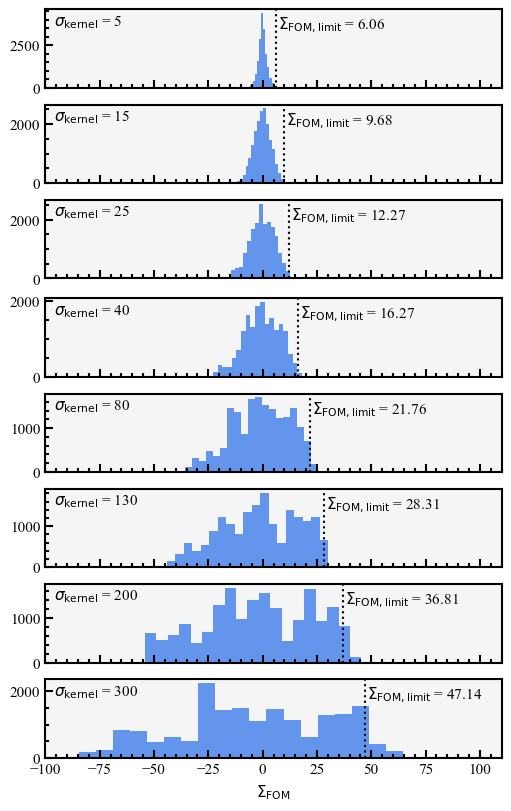

In [26]:
if plot:
    plot_fom_dists(sigma_kerns, all_fom_dict, all_fom_limits, xlims=xlims, save=save)

#### Plot: all pre-SN and control light curve $\Sigma_{\rm FOM}$ for each $\sigma_{\rm kernel}$

In [27]:
# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]

# Plot SN and control light curve FOM?:
plot = True

# Save plot?:
save = True

Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Saving plot: ./2023ixf/bump_analysis/plots/all_foms1.png


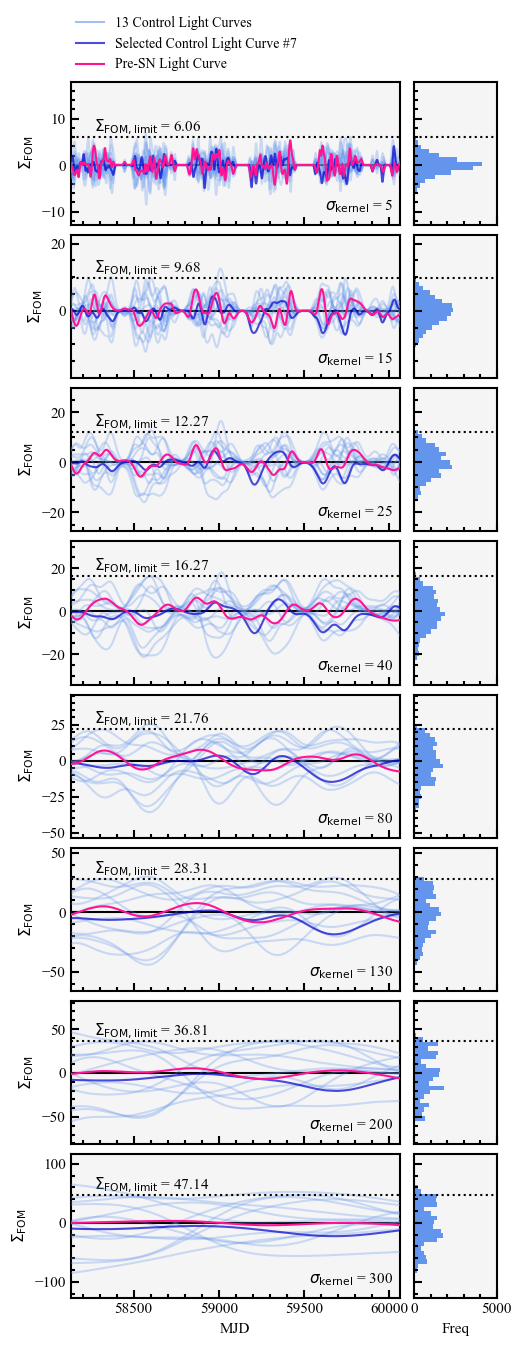

In [28]:
if plot:
    plot_all_fom(lc, select_index, sigma_kerns, all_fom_dict, skip_control_ix=skip_control_ix, all_fom_limits=all_fom_limits, mjd_ranges=mjd_ranges_include, save_filename='all_foms1', save=save)

In [29]:
# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 40, 80]

# Plot SN and control light curve FOM?:
plot = True

# Save plot?:
save = True

Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...
Saving plot: ./2023ixf/bump_analysis/plots/all_foms2.png


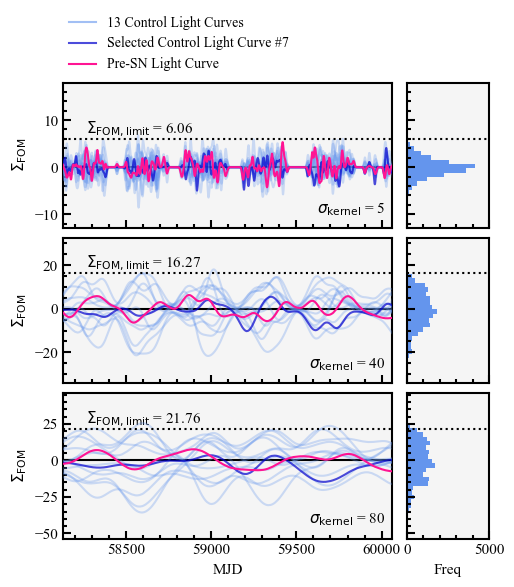

In [30]:
if plot:
    plot_all_fom(lc, select_index, sigma_kerns, all_fom_dict, skip_control_ix=skip_control_ix, all_fom_limits=all_fom_limits, mjd_ranges=mjd_ranges_include, save_filename='all_foms2', save=save)

## Efficiencies

In [ ]:
# Load effiency tables?
load = True
load_filename = 'efficiencies_include'

# Save efficiency tables?
save = False
save_filename = 'efficiencies_include'

sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]
sigma_sims = [[2, 5, 20, 40, 80, 120], # 5
              [2, 5, 20, 40, 80, 120], # 15
              [2, 5, 20, 40, 80, 120], # 15
              [5, 20, 40, 80, 110, 150, 200, 250], # 40
              [5, 20, 40, 80, 110, 150, 200, 250], # 80
              [20, 40, 80, 110, 150, 200, 250, 300], # 130
              [20, 40, 80, 110, 150, 200, 250, 300], # 200
              [20, 40, 80, 110, 150, 200, 250, 300]] # 300
peak_fluxes = [2.29, 3.22, 4.52, 6.34, 8.9, 12.5, 17.55, 24.64, 34.59, 48.56, 68.18, 95.73, 134.41, 188.71, 264.95, 371.99, 522.27, 733.27, 1029.51, 1445.44]
peak_appmags = [23.0, 22.63, 22.26, 21.89, 21.53, 21.16, 20.79, 20.42, 20.05, 19.68, 19.32, 18.95, 18.58, 18.21, 17.84, 17.47, 17.11, 16.74, 16.37, 16.0]

In [32]:
def load_efficiencies(sigma_kerns, peak_appmags, peak_fluxes, sigma_sims, fom_limits, tables_dir, mjd_ranges, load_filename=None, save_filename=None, sd=None, load=False, save=False):
    print(f'\nInitializing efficiency table for MJD ranges {mjd_ranges}')
    print(f'sigma_kerns: {sigma_kerns}')
    print(f'sigma_sims: {sigma_sims}')
    print(f'FOM limits: {fom_limits}')
    
    e = EfficiencyTable(sigma_kerns, peak_appmags, peak_fluxes, sigma_sims, fom_limits=fom_limits)
    #e.set_fom_limits(fom_limits)
    print(f'sigma_kerns: {e.sigma_kerns}')
    print(f'sigma_sims: {e.sigma_sims}')
    print(f'FOM limits: {e.fom_limits}')

    if load:
        if load_filename is None:
            raise RuntimeError(f'ERROR: load set to {load} but load_filename is None')
        e.load(tables_dir, load_filename) # load sample 1 efficiency table
    else:
        # recalculate efficiencies using FOM limits
        e.reset()
        if sd is None:
            raise RuntimeError(f'ERROR: load set to {load} but sd (simulation detection tables dictionary) is None')
        print(f'Recalculating efficiencies...')
        e.get_efficiencies(sd, valid_seasons=mjd_ranges)
        print('Success')

    if save:
        e.save(tables_dir, filename=save_filename)

    return e

print('Loading all simulation detection tables...')
sd = load_sd_dict(sigma_kerns, peak_appmags, tables_dir)
print('Success')

e = load_efficiencies(sigma_kerns, peak_appmags, peak_fluxes, sigma_sims, all_fom_limits, tables_dir, mjd_ranges_include,
                      load_filename=load_filename, save_filename=save_filename, sd=sd, load=load, save=save)
print(e.t.to_string())

Loading all simulation detection tables...
Loading simulation detection table simdetec_5_23.00.txt...
Loading simulation detection table simdetec_5_22.63.txt...
Loading simulation detection table simdetec_5_22.26.txt...
Loading simulation detection table simdetec_5_21.89.txt...
Loading simulation detection table simdetec_5_21.53.txt...
Loading simulation detection table simdetec_5_21.16.txt...
Loading simulation detection table simdetec_5_20.79.txt...
Loading simulation detection table simdetec_5_20.42.txt...
Loading simulation detection table simdetec_5_20.05.txt...
Loading simulation detection table simdetec_5_19.68.txt...
Loading simulation detection table simdetec_5_19.32.txt...
Loading simulation detection table simdetec_5_18.95.txt...
Loading simulation detection table simdetec_5_18.58.txt...
Loading simulation detection table simdetec_5_18.21.txt...
Loading simulation detection table simdetec_5_17.84.txt...
Loading simulation detection table simdetec_5_17.47.txt...
Loading simul

### Plot: efficiencies

In [33]:
# Plot efficiencies?:
plot = True

# Save plots?:
save = True

Saving plot: ./2023ixf/bump_analysis/plots/efficiency_5.png
Saving plot: ./2023ixf/bump_analysis/plots/efficiency_15.png
Saving plot: ./2023ixf/bump_analysis/plots/efficiency_25.png
Saving plot: ./2023ixf/bump_analysis/plots/efficiency_40.png
Saving plot: ./2023ixf/bump_analysis/plots/efficiency_80.png
Saving plot: ./2023ixf/bump_analysis/plots/efficiency_130.png
Saving plot: ./2023ixf/bump_analysis/plots/efficiency_200.png
Saving plot: ./2023ixf/bump_analysis/plots/efficiency_300.png


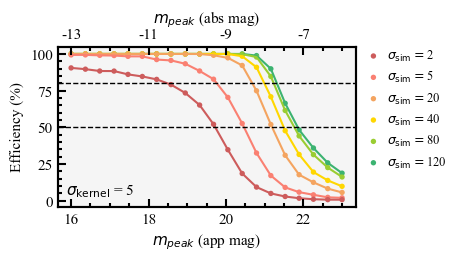

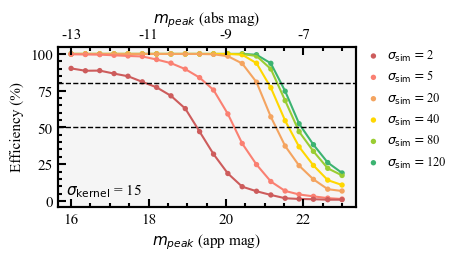

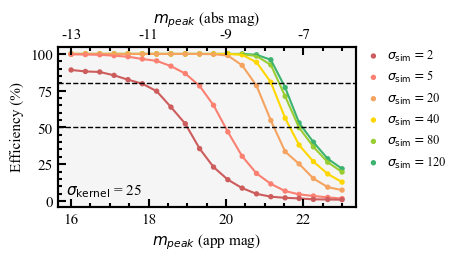

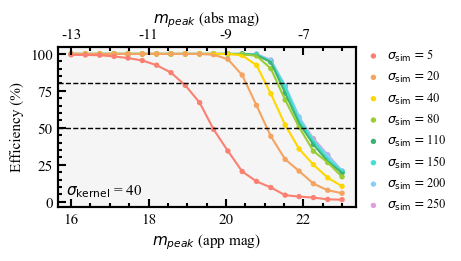

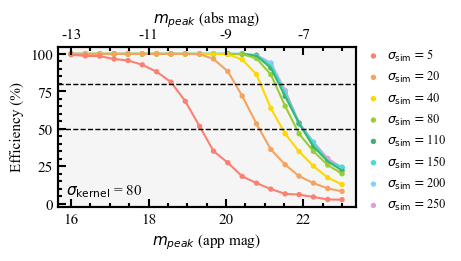

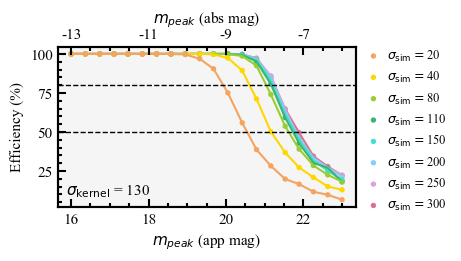

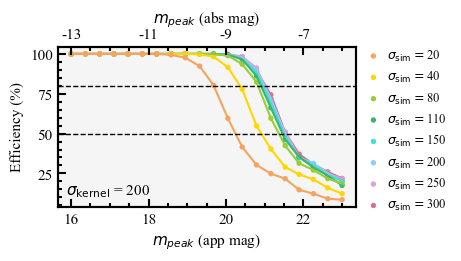

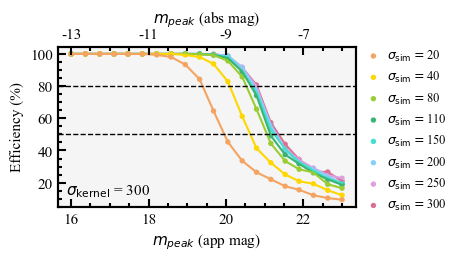

In [34]:
if plot:
    for sigma_kern in e.sigma_kerns:
        plot_efficiency(e, sigma_kern, save=save)

### Get magnitude thresholds for 50% and 80% efficiency

In [35]:
# Save magnitude threshold tables?
save = True

In [36]:
def get_mag_threshold(x, y, percent):
    lx = x.to_list()
    lx.reverse()
    ly = y.to_list()
    ly.reverse()

    ly_reduced = np.array(ly) - percent
    freduced = interpolate.UnivariateSpline(lx, ly_reduced, s=0)
    roots = freduced.roots()
    if len(roots) > 1:
        #raise RuntimeError(f'ERROR: Found more than one root: {roots}')
        print(f'WARNING: Found more than one root {roots}; returning NaN')
        return np.nan
    if len(roots) < 1:
        return np.nan
    return roots[0]

def get_mag_threshold_table(e, save=False, save_filename='mag_thresholds'):
    mt = pd.DataFrame(columns=['sigma_kern', 'sigma_sim', 'fom_limit', 'mag_threshold_50', 'mag_threshold_80'])

    row = 0
    for sigma_kern in e.sigma_kerns:
        for sigma_sim in e.sigma_sims[sigma_kern]:
            for fom_limit in e.fom_limits[sigma_kern]:
                subset = e.get_subset(sigma_kern=sigma_kern, sigma_sim=sigma_sim, fom_limit=fom_limit)
                mag_threshold_80 = get_mag_threshold(subset['peak_appmag'], subset[f'pct_detec_{fom_limit:0.2f}'], 80)
                mag_threshold_50 = get_mag_threshold(subset['peak_appmag'], subset[f'pct_detec_{fom_limit:0.2f}'], 50)
                mt.loc[row] = {'sigma_kern':sigma_kern, 'sigma_sim':sigma_sim, 'fom_limit':fom_limit, 'mag_threshold_50':mag_threshold_50, 'mag_threshold_80':mag_threshold_80}
                row += 1

    print(mt.to_string(index=False))
    if save:
        mt.to_string(f'{tables_dir}/{save_filename}.txt')
    return mt

print('Calculating magnitude thresholds for valid seasons...')
mt = get_mag_threshold_table(e, save=save, save_filename='mag_thresholds_include')

Calculating magnitude thresholds for valid seasons...
 sigma_kern  sigma_sim  fom_limit  mag_threshold_50  mag_threshold_80
          5          2       6.06         19.726131         18.502567
          5          5       6.06         20.467136         19.785387
          5         20       6.06         21.190412         20.699751
          5         40       6.06         21.488097         21.011765
          5         80       6.06         21.750835         21.239820
          5        120       6.06         21.846925         21.327379
         15          2       9.68         19.257621         17.943476
         15          5       9.68         20.214751         19.514761
         15         20       9.68         21.279454         20.804826
         15         40       9.68         21.611646         21.107154
         15         80       9.68         21.832060         21.345766
         15        120       9.68         21.942700         21.443607
         25          2      12.27   

In [37]:
best_mt = pd.DataFrame(columns=['sigma_sim','best_m_threshold_80','best_sigma_kern_80','best_m_threshold_50','best_sigma_kern_50'])

sigma_sims = [2, 5, 20, 40, 80, 110, 120, 150, 200, 250, 300]

for i in range(len(sigma_sims)):
    sigma_sim = sigma_sims[i]
    sigma_sim_ix = mt[mt['sigma_sim'] == sigma_sim].index

    best_m_threshold_80 = -np.inf
    best_m_threshold_50 = -np.inf
    best_sigma_kern_80 = np.nan
    best_sigma_kern_50 = np.nan
    
    for sigma_kern in e.sigma_kerns:
        sigma_kern_ix = mt[mt['sigma_kern'] == sigma_kern].index
        ix = AandB(sigma_kern_ix, sigma_sim_ix)
        
        for j in ix:
            if mt.loc[j,'mag_threshold_80'] > best_m_threshold_80:
                best_m_threshold_80 = mt.loc[j,'mag_threshold_80']
                best_sigma_kern_80 = mt.loc[j,'sigma_kern']

            if mt.loc[i,'mag_threshold_50'] > best_m_threshold_50:
                best_m_threshold_50 = mt.loc[j,'mag_threshold_50']
                best_sigma_kern_50 = mt.loc[j,'sigma_kern']
    
    best_mt.loc[i,:] = {
        'sigma_sim': sigma_sim,
        'best_m_threshold_80': best_m_threshold_80,
        'best_sigma_kern_80': best_sigma_kern_80,
        'best_m_threshold_50': best_m_threshold_50,
        'best_sigma_kern_50': best_sigma_kern_50
    }

print(best_mt.to_string())

   sigma_sim best_m_threshold_80 best_sigma_kern_80 best_m_threshold_50 best_sigma_kern_50
0        2.0           18.502567                5.0           19.726131                5.0
1        5.0           19.785387                5.0           20.467136                5.0
2       20.0           20.804826               15.0           21.190412                5.0
3       40.0           21.173438               25.0           21.488097                5.0
4       80.0           21.395946               25.0           21.750835                5.0
5      110.0           21.431003               40.0           21.960285               40.0
6      120.0           21.487262               25.0           21.846925                5.0
7      150.0           21.488279               40.0            21.99779               40.0
8      200.0           21.503602               40.0           22.041988               40.0
9      250.0           21.501172               40.0           22.043102               40.0

### Plot: magnitude thresholds

In [38]:
# Plot magnitude thresholds?
plot = True

# Enter plot y limits:
ylims = (16.8, 22.3)

# Use log scale for x axis?
log = True

# Save plot?:
save = True

Saving plot: ./2023ixf/bump_analysis/plots/mag_thresholds_log.png


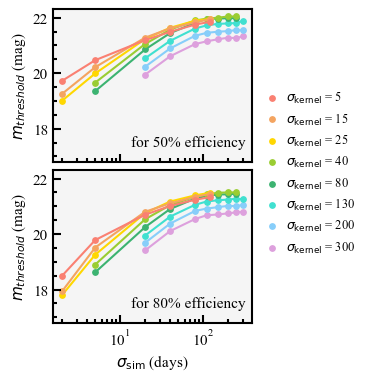

In [39]:
if plot:
    save_filename = 'mag_thresholds_log' if log else 'mag_thresholds'
    save_filename_exclude = 'mag_thresholds_log_exclude' if log else 'mag_thresholds_exclude'
    plot_mag_thresholds(e, mt, ylims=ylims, log=log, save=save, save_filename=save_filename)

### Excluded MJD ranges

In [40]:
sigma_kerns = [5, 80]
sigma_sims = [5, 80]
faintest_mag = 18

# excluded observation seasons
mjd_ranges_exclude_crit1 = [mjd_ranges_remove[0]] 

# observation season gaps
mjd_ranges_exclude_gaps = get_mjd_ranges_inverse(mjd_ranges)

# fine-tuned observation season gaps
mjd_ranges_exclude_crit2 = expand_mjd_ranges_by(add_mjd_ranges_to(mjd_ranges, [mjd_ranges_remove[1]]), indices=[0, 1, 2, 4, 5, 7, 8], exclude_obs_edges=exclude_obs_edges)

In [41]:
def concat_sd(sd, sigma_kern, faintest_mag):
    print(f'\nConcatenating SimDetecTables for sigma_kern {sigma_kern} with peak_mag<={faintest_mag}...')

    columns = ['sigma_kern', 'peak_appmag', 'peak_flux', 'peak_mjd', 'sigma_sim', 'max_fom', 'max_fom_mjd']
    sd_concat = pdastrostatsclass()
    sd_concat.t = pd.DataFrame(columns=columns)

    for peak_mag in e.peak_appmags:
        if peak_mag <= faintest_mag:
            print(f'# Appending detected table with peak mag {peak_mag}...')
            sd_concat.t = pd.concat([sd_concat.t, sd[f'{sigma_kern}_{peak_mag:0.2f}'].t[columns]])

    sd_concat.t.reset_index(inplace=True, drop=True)

    assert len(e.fom_limits[sigma_kern]) == 1
    fom_limit = e.fom_limits[sigma_kern][0]
    print(f'# Adding boolean detected column using FOM limit {fom_limit:0.2f}...')
    sd_concat.t['fom_limit'] = np.full(len(sd_concat.t), fom_limit) 
    sd_concat.t['detected'] = sd_concat.t['max_fom'].apply(lambda max_fom: max_fom >= fom_limit)
    print('# Success')

    return sd_concat

def get_effs(sd, e, sigma_kern, sigma_sim, mjd_ranges=None):
    effs = {peak_mag: None for peak_mag in e.peak_appmags}
    fom_limit = e.fom_limits[sigma_kern][0]
    for peak_mag in e.peak_appmags:
        eff = sd[f'{sigma_kern}_{peak_mag:0.2f}'].get_efficiency(fom_limit, valid_seasons=mjd_ranges, sigma_sim=sigma_sim)
        effs[peak_mag] = eff
    return effs

sd_concat_dict = {}
effs_dict = {}

for i in range(len(sigma_kerns)):
    sigma_kern = sigma_kerns[i]
    sigma_sim = sigma_sims[i]

    sd_concat_dict[sigma_kern] = concat_sd(sd, sigma_kern, faintest_mag)

    print(f'Getting efficiencies for sigma_kern {sigma_kern} and sigma_sim {sigma_sim}...')
    effs0 = get_effs(sd, e, sigma_kern, sigma_sim)
    effs_crit1 = get_effs(sd, e, sigma_kern, sigma_sim, mjd_ranges=get_mjd_ranges_inverse(mjd_ranges_exclude_crit1))
    effs_gaps = get_effs(sd, e, sigma_kern, sigma_sim, mjd_ranges=get_mjd_ranges_inverse(mjd_ranges_exclude_gaps))
    effs_crit2 = get_effs(sd, e, sigma_kern, sigma_sim, mjd_ranges=get_mjd_ranges_inverse(mjd_ranges_exclude_crit2))
    effs_exclude = get_effs(sd, e, sigma_kern, sigma_sim, mjd_ranges=get_mjd_ranges_inverse(mjd_ranges_exclude))

    effs_dict[sigma_kern] = [effs0, effs_crit1, effs_gaps, effs_crit2, effs_exclude]


Concatenating SimDetecTables for sigma_kern 5 with peak_mag<=18...
# Appending detected table with peak mag 17.84...
# Appending detected table with peak mag 17.47...
# Appending detected table with peak mag 17.11...
# Appending detected table with peak mag 16.74...
# Appending detected table with peak mag 16.37...
# Appending detected table with peak mag 16.0...
# Adding boolean detected column using FOM limit 6.06...
# Success
Getting efficiencies for sigma_kern 5 and sigma_sim 5...

Concatenating SimDetecTables for sigma_kern 80 with peak_mag<=18...
# Appending detected table with peak mag 17.84...
# Appending detected table with peak mag 17.47...
# Appending detected table with peak mag 17.11...
# Appending detected table with peak mag 16.74...
# Appending detected table with peak mag 16.37...
# Appending detected table with peak mag 16.0...
# Adding boolean detected column using FOM limit 21.76...
# Success
Getting efficiencies for sigma_kern 80 and sigma_sim 80...


#### Plot: excluded MJD ranges

Saving plot: ./2023ixf/bump_analysis/plots/mjd_ranges_hist2_5.png


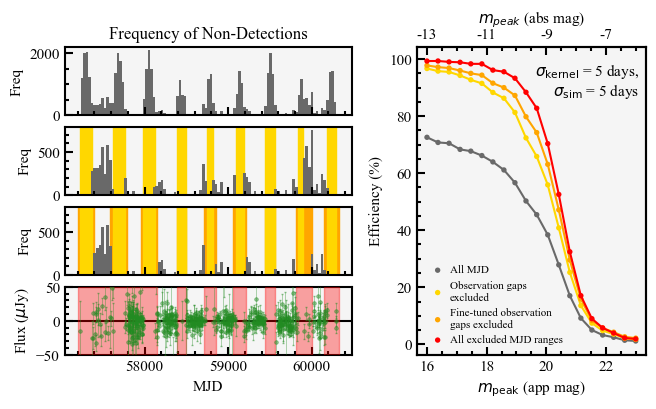

In [42]:
def plot_sim_hists2(sigma_kern, sigma_sim, effs, sd_concat):
    pos_ix = np.where(sd_concat.t['detected'])[0]
    neg_ix = AnotB(sd_concat.t.index.values, pos_ix)
    ix_crit1 = get_valid_ix(sd_concat.t, 'peak_mjd', get_mjd_ranges_inverse(mjd_ranges_exclude_crit1))
    ix_gaps = get_valid_ix(sd_concat.t, 'peak_mjd', get_mjd_ranges_inverse(mjd_ranges_exclude_gaps))
    ix_crit2 = get_valid_ix(sd_concat.t, 'peak_mjd', get_mjd_ranges_inverse(mjd_ranges_exclude_crit2))

    color0 = 'dimgray'
    color_gaps = 'gold' 
    color_crit2 = 'orange' 
    color_exclude = 'red'

    fig = plt.figure(constrained_layout=True)
    fig.set_figheight(4)
    fig.set_figwidth(7.5)
    gs = GridSpec(4, 2, figure=fig, width_ratios=[5,4], wspace=0.25, hspace=0.17)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[2,0])
    ax4 = fig.add_subplot(gs[3,0])
    ax5 = fig.add_subplot(gs[0:,1])
    fig.tight_layout()

    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.minorticks_on()
        ax.tick_params(direction='in', which='both')
        ax.set_facecolor(facecolor)
        
    ax4.set_xlabel('MJD')
    ax4.set_ylim(-50, 50)
    ax4.set_ylabel(r'Flux ($\mu$Jy)')
    ax4.axhline(linewidth=1.5, color='k', zorder=0)
    good_ix = lc.get_unmasked_ix(flags, control_index=select_index) 
    ax4.errorbar(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[select_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=0.5, capsize=1, c=select_ctrl_flux, alpha=0.5, zorder=40)
    ax4.scatter(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], s=7, lw=0.5, color=select_ctrl_flux, marker='o', alpha=0.5, label=f'Cleaned Pre-SN Light Curve', zorder=40)
    for mjd_range in mjd_ranges_exclude:
        ax4.axvspan(mjd_range[0], mjd_range[1], color=color_exclude, alpha=0.35, zorder=30)
    xlim_lower, xlim_upper = ax4.get_xlim()

    bins = np.linspace(min(sd_concat.t['peak_mjd']), max(sd_concat.t['peak_mjd']), 100)
  
    ax1.set_title('Frequency of Non-Detections', fontsize=12)
    ax1.set_xticklabels([])
    ax1.hist(sd_concat.t.loc[neg_ix, 'peak_mjd'], color=color0, alpha=1, bins=bins, zorder=-10)

    ax2.set_xticklabels([])
    for mjd_range in mjd_ranges_exclude_gaps:
        ax2.axvspan(mjd_range[0], mjd_range[1], color=color_gaps, alpha=1, zorder=-30)
    ax2.hist(sd_concat.t.loc[AandB(ix_gaps, neg_ix), 'peak_mjd'], color=color0, alpha=1, bins=bins, zorder=-20)
    ylim_lower, ylim_upper = ax2.get_ylim()

    ax3.set_xticklabels([])
    ax3.set_ylim(ylim_lower, ylim_upper)
    for mjd_range in mjd_ranges_exclude_gaps:
        ax3.axvspan(mjd_range[0], mjd_range[1], color=color_gaps, alpha=1, zorder=-30)
    for mjd_range in mjd_ranges_exclude_crit2:
        ax3.axvspan(mjd_range[0], mjd_range[1], color=color_crit2, alpha=1, zorder=-40)
    ax3.hist(sd_concat.t.loc[AandB(ix_crit2, neg_ix), 'peak_mjd'], color=color0, alpha=1, bins=bins, zorder=-20)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(xlim_lower, xlim_upper)
        ax.set_ylabel('Freq')

    # efficiency plot

    ax5.set_xlabel(r'$m_{\rm peak}$ (app mag)')
    ax5.set_ylabel('Efficiency (%)')
    ax5.text(.97, .95, r'$\sigma_{\rm kernel}$ = '+f'{sigma_kern} days,\n'+r'$\sigma_{\rm sim}$ = '+f'{sigma_sim} days',ha='right', va='top', transform=ax5.transAxes, fontsize=11)

    ax5.scatter(effs[0].keys(), effs[0].values(), color=color0, edgecolors='none', marker='o', s=15, label='All MJD', zorder=10)
    ax5.plot(effs[0].keys(), effs[0].values(), color=color0, zorder=10)
    ax5.scatter(effs[2].keys(), effs[2].values(), color=color_gaps, edgecolors='none', marker='o', s=15, label='Observation gaps \nexcluded', zorder=30)
    ax5.plot(effs[2].keys(), effs[2].values(), color=color_gaps, zorder=30)
    ax5.scatter(effs[3].keys(), effs[3].values(), color=color_crit2, edgecolors='none', marker='o', s=15, label='Fine-tuned observation \ngaps excluded', zorder=30)
    ax5.plot(effs[3].keys(), effs[3].values(), color=color_crit2, zorder=30)
    ax5.scatter(effs[4].keys(), effs[4].values(), color=color_exclude, edgecolors='none', marker='o', s=15, label='All excluded MJD ranges', zorder=30)
    ax5.plot(effs[4].keys(), effs[4].values(), color=color_exclude, zorder=30)
    ax5.legend(loc='lower left', facecolor='white', fontsize=8, handletextpad=0.1, framealpha=0).set_zorder(100)

    ax6 = ax5.twiny()
    ax6.set_xticks(ax5.get_xticks())
    ax6.set_xbound(ax5.get_xbound())
    ax6.minorticks_on()
    ax6.tick_params(direction='in', which='both')
    ax6.set_facecolor(facecolor)
    ax6.set_xticklabels([round(x-29.04) for x in ax5.get_xticks()])
    ax6.set_xlabel(r'$m_{peak}$ (abs mag)')

    save_plot(save_filename=f'mjd_ranges_hist2_{sigma_kern}')

for i in range(len(sigma_kerns)):
    sigma_kern = sigma_kerns[i]
    plot_sim_hists2(sigma_kern, sigma_sims[i], effs_dict[sigma_kern], sd_concat_dict[sigma_kern])
    break

### Get $3\sigma$ FOM limits

In [43]:
sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]
sigma_sims = [[2, 5, 20, 40, 80, 120], # 5
              [2, 5, 20, 40, 80, 120], # 15
              [2, 5, 20, 40, 80, 120], # 15
              [5, 20, 40, 80, 110, 150, 200, 250], # 40
              [5, 20, 40, 80, 110, 150, 200, 250], # 80
              [20, 40, 80, 110, 150, 200, 250, 300], # 130
              [20, 40, 80, 110, 150, 200, 250, 300], # 200
              [20, 40, 80, 110, 150, 200, 250, 300]] # 300
peak_fluxes = [2.29, 3.22, 4.52, 6.34, 8.9, 12.5, 17.55, 24.64, 34.59, 48.56, 68.18, 95.73, 134.41, 188.71, 264.95, 371.99, 522.27, 733.27, 1029.51, 1445.44]
peak_appmags = [23.0, 22.63, 22.26, 21.89, 21.53, 21.16, 20.79, 20.42, 20.05, 19.68, 19.32, 18.95, 18.58, 18.21, 17.84, 17.47, 17.11, 16.74, 16.37, 16.0]

In [44]:
def get_fom_limit_3sigma(sigma_kern, all_fom):#, plot=False):
    df = pdastrostatsclass(columns=['SNRsumnorm'])
    df.t['SNRsumnorm'] = all_fom
    df.calcaverage_sigmacutloop('SNRsumnorm', Nsigma=3.0, median_firstiteration=True)
    stdev = df.statparams["stdev"]
    mean = df.statparams["mean"]
    fom_limit_3sig = mean + 3*stdev
    #fom_limit_5sig = mean + 5*stdev
    print(f'sigma_kern={sigma_kern}: stdev={df.statparams["stdev"]:0.2f}, 3*stdev={fom_limit_3sig:0.2f}')#, 5*stdev={fom_limit_5sig:0.2f}')
    return fom_limit_3sig

def get_fom_limits_3sigma(sigma_kerns, all_fom_dict):
    print(f'Getting FOM limits for sigma_kerns {sigma_kerns}')
    fom_limits = { sigma_kern: None for sigma_kern in sigma_kerns }
    for sigma_kern in sigma_kerns: 
        fom_limit = get_fom_limit_3sigma(sigma_kern, all_fom_dict[sigma_kern])
        fom_limits[sigma_kern] = [round(fom_limit, 2)]
    return fom_limits

fom_limits_3sigma = get_fom_limits_3sigma(sigma_kerns, all_fom_dict)
print(fom_limits_3sigma)

Getting FOM limits for sigma_kerns [5, 15, 25, 40, 80, 130, 200, 300]
sigma_kern=5: stdev=1.86, 3*stdev=5.51
sigma_kern=15: stdev=3.92, 3*stdev=11.62
sigma_kern=25: stdev=5.74, 3*stdev=16.96
sigma_kern=40: stdev=8.18, 3*stdev=24.12
sigma_kern=80: stdev=13.16, 3*stdev=38.60
sigma_kern=130: stdev=17.99, 3*stdev=52.47
sigma_kern=200: stdev=24.85, 3*stdev=72.13
sigma_kern=300: stdev=34.39, 3*stdev=99.48
{5: [5.51], 15: [11.62], 25: [16.96], 40: [24.12], 80: [38.6], 130: [52.47], 200: [72.13], 300: [99.48]}


In [45]:
contam_3sigma = get_contamination_table(lc, sigma_kerns, fom_limits_3sigma, mjd_ranges_include, skip_control_ix)
print(contam_3sigma.to_string())

   sigma_kern  fom_limit  n_falsepos  n_pos_controls  pct_pos_controls  n_falsepos_00  n_falsepos_01  n_falsepos_04  n_falsepos_05  n_falsepos_06  n_falsepos_07  n_falsepos_08  n_falsepos_09  n_falsepos_10  n_falsepos_11  n_falsepos_12  n_falsepos_13  n_falsepos_14  n_falsepos_15  n_falsepos_16
0           5       5.51          13               8             57.14              0              0              1              1              2              0              0              1              1              2              1              0              4              0              0
1          15      11.62           1               1              7.14              0              0              0              0              0              0              0              0              0              0              0              0              1              0              0
2          25      16.96           0               0              0.00              0              0            

Saving plot: ./2023ixf/bump_analysis/plots/contam_3sigma.png


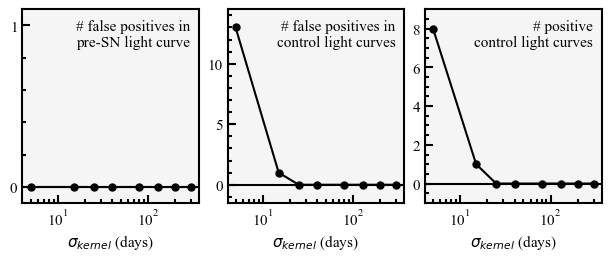

In [46]:
def plot_contamination(contam, base=10, save=False, save_filename='contam'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
    fig.set_figwidth(6)
    fig.set_figheight(2.5)

    color = 'k' 
    markersize = 25

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel(r'$\sigma_{kernel}$ (days)')
        ax.set_facecolor(facecolor)
        ax.axhline(color='k', zorder=0)
        ax.minorticks_on()
        ax.tick_params(direction='in', which='both')

    ax1.scatter(contam['sigma_kern'], contam['n_falsepos_00'], color=color, edgecolors='k', marker='o', s=markersize, zorder=30)
    ax1.semilogx(contam['sigma_kern'], contam['n_falsepos_00'], color='k', zorder=20, base=base)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks([0,1], labels=[0,1])
    ax1.text(.95, .95, f'# false positives in\npre-SN light curve', ha='right', va='top', transform=ax1.transAxes, fontsize=11, zorder=100)
    
    ax2.scatter(contam['sigma_kern'], contam['n_falsepos'], color=color, edgecolors='k', marker='o', s=markersize, zorder=30)
    ax2.semilogx(contam['sigma_kern'], contam['n_falsepos'], color='k', zorder=20, base=base)
    #ax2.set_yticks(range(0,15,2), labels=range(0,15,2))
    ax2.set_ylim(-1.5,14.5)
    ax2.text(.95, .95, f'# false positives in\ncontrol light curves', ha='right', va='top', transform=ax2.transAxes, fontsize=11, zorder=100)

    ax3.scatter(contam['sigma_kern'], contam['n_pos_controls'], color=color, edgecolors='k', marker='o', s=markersize, zorder=30)
    ax3.semilogx(contam['sigma_kern'], contam['n_pos_controls'], color='k', zorder=20, base=base)
    ax3.set_ylim(-1,9)
    ax3.set_yticks(range(0,9,2), labels=range(0,9,2))
    ax3.text(.95, .95, f'# positive\ncontrol light curves', ha='right', va='top', transform=ax3.transAxes, fontsize=11, zorder=100)

    if save:
        save_plot(save_filename=save_filename)

if plot:
    plot_contamination(contam_3sigma, save=True, save_filename='contam_3sigma')

In [47]:
e_3sigma = load_efficiencies(sigma_kerns, peak_appmags, peak_fluxes, sigma_sims, fom_limits_3sigma, tables_dir, mjd_ranges_include,
                             save=True, save_filename='efficiencies_3sigma', sd=sd)
print(e_3sigma.t.to_string())
#plot_efficiency(e_3sigma, 80, save=True, save_filename='efficiencies_80_3sigma')


Initializing efficiency table for MJD ranges [[58150, 58383], [58494, 58711], [58852, 59063], [59214, 59445], [59566, 59806], [60001, 60151]]
sigma_kerns: [5, 15, 25, 40, 80, 130, 200, 300]
sigma_sims: [[2, 5, 20, 40, 80, 120], [2, 5, 20, 40, 80, 120], [2, 5, 20, 40, 80, 120], [5, 20, 40, 80, 110, 150, 200, 250], [5, 20, 40, 80, 110, 150, 200, 250], [20, 40, 80, 110, 150, 200, 250, 300], [20, 40, 80, 110, 150, 200, 250, 300], [20, 40, 80, 110, 150, 200, 250, 300]]
FOM limits: {5: [5.51], 15: [11.62], 25: [16.96], 40: [24.12], 80: [38.6], 130: [52.47], 200: [72.13], 300: [99.48]}
sigma_kerns: [5, 15, 25, 40, 80, 130, 200, 300]
sigma_sims: {5: [2, 5, 20, 40, 80, 120], 15: [2, 5, 20, 40, 80, 120], 25: [2, 5, 20, 40, 80, 120], 40: [5, 20, 40, 80, 110, 150, 200, 250], 80: [5, 20, 40, 80, 110, 150, 200, 250], 130: [20, 40, 80, 110, 150, 200, 250, 300], 200: [20, 40, 80, 110, 150, 200, 250, 300], 300: [20, 40, 80, 110, 150, 200, 250, 300]}
FOM limits: {5: [5.51], 15: [11.62], 25: [16.96], 40

 sigma_kern  sigma_sim  fom_limit  mag_threshold_50  mag_threshold_80
          5          2       5.51         19.829563         18.614040
          5          5       5.51         20.577730         19.877830
          5         20       5.51         21.322169         20.799524
          5         40       5.51         21.665092         21.119658
          5         80       5.51         21.972299         21.373194
          5        120       5.51         22.060580         21.469873
         15          2      11.62         19.062285         17.746097
         15          5      11.62         20.025701         19.299784
         15         20      11.62         21.074115         20.622468
         15         40      11.62         21.375435         20.929312
         15         80      11.62         21.590808         21.152217
         15        120      11.62         21.679254         21.242465
         25          2      16.96         18.630207         17.442652
         25         

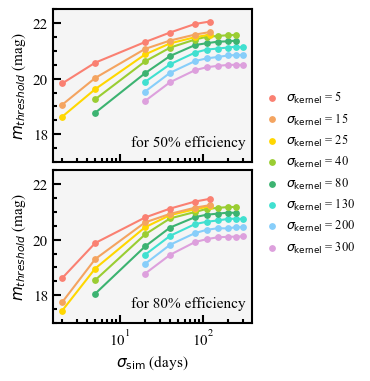

In [48]:
mt_3sigma = get_mag_threshold_table(e_3sigma)
plot_mag_thresholds(e_3sigma, mt_3sigma, ylims=(17, 22.5), log=log, save=save, save_filename='mag_thresholds_3sigma')

## Supplementary plots: simulating pre-SN outburts

### Plot: adding a simulated Gaussian bump

In [49]:
# Plot simulated bumps?:
plot = True

# Enter the sigmas of each of the simulated Gaussian bumps to plot:
sigma_sims = [5, 80, 200]

# Enter the peak MJDs of the simulated bumps:
sim_peak_mjds = [58600, 58600, 58600] 

# Enter the peak fluxes of the simulated bumps:
sim_peak_fluxes = [30, 30, 30]

# Enter the sigmas of the weighted Gaussian rolling sums to be applied to the light curve:
sigma_kerns = [5, 80, 200]

# Enter the abs value of the flux y limits for each simulated bump:
ylims_flux = [40, 50, 50, 50]

# Enter the abs value of the FOM y limits for each simulated bump:
ylims_fom = [13, 200, 200]

# Save plots?:
save = [True, True, True]

Saving plot: ./2023ixf/bump_analysis/plots/simbump_5.png
Crosses FOM limit 6.06 at 58592.5 MJD


SystemExit: 

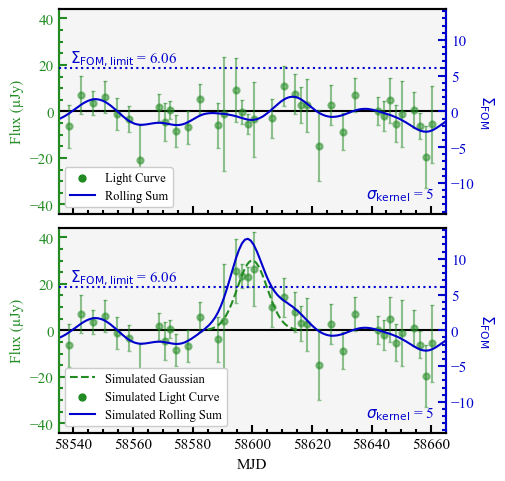

In [50]:
def get_detec_mjd(sim_lc, fom_limit):
    for i in range(len(sim_lc.t)):
        if sim_lc.t.loc[i,'SNRsimsum'] > fom_limit:
            return sim_lc.t.loc[i,'MJDbin']

def plot_sim_bump(sim_lc, sigma_kern, fom_limits, sigma_sim, sim_peak_flux, sim_peak_mjd, ylim_fom=None, ylim_flux=None, plot_gauss=True, save=False):
    fig2, (ax1, ax3) = plt.subplots(2, gridspec_kw = {'hspace':0.07})#, constrained_layout=True)
    fig2.set_figwidth(5)
    fig2.set_figheight(5.5)
    fig2.tight_layout()
    
    ax1.set_xticklabels([])
    ax3.set_xlabel('MJD')

    for ax in [ax1, ax3]:
        ax.tick_params(axis='y', which='both', colors=select_ctrl_flux)
        ax.spines["left"].set_color(select_ctrl_flux)
        ax.axhline(linewidth=1.5,color='k')
        ax.set_ylabel(r'Flux (µJy)', color=select_ctrl_flux)
        ax.set_ylim(-ylim_flux*1.1, ylim_flux*1.1)
        ax.text(.97, .05, r'$\sigma_{\rm kernel}$ = '+f'{sigma_kern}', color=select_ctrl_fom, ha='right', va='bottom', transform=ax.transAxes, fontsize=11)


    ax2 = ax1.twinx()
    ax4 = ax3.twinx()

    for ax in [ax1, ax2, ax3, ax4]:
        ax.minorticks_on()
        ax.tick_params(direction='in', which='both')
        ax.set_xlim(sim_peak_mjd-65, sim_peak_mjd+65)
        #ax.set_xlim(sim_peak_mjd-sigma_sim*8, sim_peak_mjd+sigma_sim*9)
        ax.set_facecolor(facecolor)
          
    for ax in [ax2, ax4]:
        ax.tick_params(axis='y', which='both', colors=select_ctrl_fom)
        ax.spines["right"].set_color(select_ctrl_fom)
        ax.spines["left"].set_color(select_ctrl_flux)
        ax.set_ylim(-ylim_fom*1.1, ylim_fom*1.1)
        ax.set_ylabel(r'$\Sigma_{\rm FOM}$', color=select_ctrl_fom, rotation=270, labelpad=15)

        # fom limits
        for fom_limit in fom_limits:
            ax.axhline(fom_limit, linewidth=1.5, color=select_ctrl_fom, linestyle=fomlimit_ls, zorder=50) 
            ax.text(0.03, fom_limit, r'$\Sigma_{\rm FOM, limit}$ = '+str(fom_limit), color=select_ctrl_fom, transform=ax.get_yaxis_transform(), ha="left", va="bottom") 


    flags_ = 0x0
    for k in flags: flags_ = flags_ | flags[k]
    
    # PANEL 1
    
    # flux
    good_ix = sim_lc.ix_unmasked('Mask',maskval=flags_)
    ax1.errorbar(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJy'], yerr=sim_lc.t.loc[good_ix,'duJy'], fmt='none', elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=20)
    ax1.scatter(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=20)

    # fom
    ax2.scatter([0,1],[0,0], color=select_ctrl_flux, alpha=1, s=marker_size, lw=marker_edgewidth, marker='o', zorder=0, label=f'Light Curve')
    ax2.plot(sim_lc.t['MJDbin'], sim_lc.t['SNRsumnorm'], color=select_ctrl_fom, linewidth=1.5, alpha=1, label='Rolling Sum')
    ax2.legend(loc='lower left', facecolor='white', framealpha=1.0).set_zorder(100)

    # PANEL 2

    # simulated flux
    good_ix = sim_lc.ix_unmasked('Mask',maskval=flags_)
    ax3.errorbar(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJysim'], yerr=sim_lc.t.loc[good_ix,'duJy'], fmt='none', elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=20)
    ax3.scatter(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJysim'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=20)

    # simulated gaussian flux
    if plot_gauss:
        def my_gauss(x, sigma=sigma_sim, h=sim_peak_flux, mid=sim_peak_mjd):
            variance = math.pow(sigma, 2)
            return h * math.exp(-math.pow(x-mid, 2)/(2*variance))
        x = np.linspace(sim_peak_mjd - 3*sigma_sim, sim_peak_mjd + 3*sigma_sim, 100)
        y = [my_gauss(xi) for xi in x]
        ax3.plot(x, y, color=select_ctrl_flux, linestyle=simbump_ls, linewidth=1.5, zorder=20)
        ax4.plot([0,1],[0,0], color=select_ctrl_flux, linestyle=simbump_ls, linewidth=1.5, alpha=1, label=f'Simulated Gaussian')

    # simulated fom
    ax4.scatter([0,1],[0,0], color=select_ctrl_flux, s=marker_size, lw=marker_edgewidth, alpha=1, marker='o', label=f'Simulated Light Curve')
    ax4.plot(sim_lc.t['MJDbin'], sim_lc.t['SNRsimsum'], color=select_ctrl_fom, linewidth=1.5, alpha=1, label=f'Simulated Rolling Sum')
    ax4.legend(loc='lower left', facecolor='white', framealpha=1.0).set_zorder(100)

    if save:
        save_plot(save_filename=f'simbump_{sigma_kern}')

if plot:
    for i in range(len(sigma_sims)):
        sigma_kern = sigma_kerns[i]
        sigma_sim = sigma_sims[i]
        sim_peak_mjd = sim_peak_mjds[i]

        gaussian = Gaussian(sigma_sim, flux2mag(sim_peak_fluxes[i]))
        lc.apply_rolling_sum(select_index, sigma_kern)
        sim_lc = lc.add_simulation(select_index, peak_mjd=sim_peak_mjd, gaussian=gaussian)

        plot_sim_bump(sim_lc, sigma_kern, e.fom_limits[sigma_kern], sigma_sim, sim_peak_fluxes[i], sim_peak_mjd, 
                      ylim_fom=ylims_fom[i], ylim_flux=ylims_flux[i], save=save[i])

        for fom_limit in e.fom_limits[sigma_kern]:
            detec_mjd = get_detec_mjd(sim_lc, fom_limit)
            print(f'Crosses FOM limit {fom_limit:0.2f} at {detec_mjd} MJD')

        sys.exit()

### Plot: adding a simulated eruption

In [51]:
# Plot simulated eruption?:
plot = True

# Enter the file name of the simulated eruption to add:
erup_filename = './eruption_m3e-07.dat'

# Enter the sigmas of the weighted Gaussian rolling sum to be applied to the light curve:
sigma_kern = 5

# Enter the peak MJD of the simulated eruption:
sim_peak_mjd = 58600

# Enter the peak app mag of the simulated eruption:
sim_peak_mag = 19.8

# Enter the abs value of the flux y limits:
ylim_flux = 50

# Enter the abs value of the FOM y limits:
ylim_fom = 13

# Save plot?:
save = True

Loading eruption lc at ./eruption_m3e-07.dat...
Crosses FOM limit 6.06 at 58593.5 MJD
Saving plot: ./2023ixf/bump_analysis/plots/simerup.png


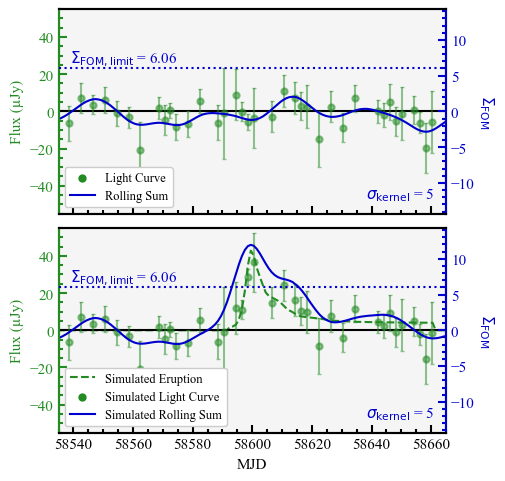

In [52]:
def plot_sim_erup(sim_lc, sim_flux, fom_limits, ylim_flux=None, ylim_fom=None, save=False):
    fig2, (ax1, ax3) = plt.subplots(2, gridspec_kw = {'hspace':0.07})#, constrained_layout=True)
    fig2.set_figwidth(5)
    fig2.set_figheight(5.5)
    fig2.tight_layout()
    
    ax1.set_xticklabels([])
    ax3.set_xlabel('MJD')

    for ax in [ax1, ax3]:
        ax.tick_params(axis='y', which='both', colors=select_ctrl_flux)
        ax.spines["left"].set_color(select_ctrl_flux)
        ax.axhline(linewidth=1.5,color='k')
        ax.set_ylabel(r'Flux (µJy)', color=select_ctrl_flux)
        ax.set_ylim(-ylim_flux*1.1, ylim_flux*1.1)
        ax.text(.97, .05, r'$\sigma_{\rm kernel}$ = '+f'{sigma_kern}', color=select_ctrl_fom, ha='right', va='bottom', transform=ax.transAxes, fontsize=11)

    ax2 = ax1.twinx()
    ax4 = ax3.twinx()

    for ax in [ax1, ax2, ax3, ax4]:
        ax.minorticks_on()
        ax.tick_params(direction='in', which='both')
        ax.set_xlim(sim_peak_mjd-65, sim_peak_mjd+65)
        ax.set_facecolor(facecolor)
          
    for ax in [ax2, ax4]:
        ax.tick_params(axis='y', which='both', colors=select_ctrl_fom)
        ax.spines["right"].set_color(select_ctrl_fom)
        ax.spines["left"].set_color(select_ctrl_flux)
        ax.set_ylim(-ylim_fom*1.1, ylim_fom*1.1)
        ax.set_ylabel(r'$\Sigma_{\rm FOM}$', color=select_ctrl_fom, rotation=270, labelpad=15)

        # fom limits
        for fom_limit in fom_limits:
            ax.axhline(fom_limit, linewidth=1.5, color=select_ctrl_fom, linestyle=fomlimit_ls, zorder=50) 
            ax.text(0.03, fom_limit, r'$\Sigma_{\rm FOM, limit}$ = '+str(fom_limit), color=select_ctrl_fom, transform=ax.get_yaxis_transform(), ha="left", va="bottom") 

    flags_ = 0x0
    for k in flags: flags_ = flags_ | flags[k]

    # PANEL 1

    # flux
    good_ix = sim_lc.ix_unmasked('Mask',maskval=flags_)
    ax1.errorbar(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJy'], yerr=sim_lc.t.loc[good_ix,'duJy'], fmt='none', elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=20)
    ax1.scatter(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=20)

    # fom
    ax2.scatter([0,1],[0,0], color=select_ctrl_flux, alpha=1, s=marker_size, lw=marker_edgewidth, marker='o', zorder=0, label=f'Light Curve')
    ax2.plot(sim_lc.t['MJDbin'], sim_lc.t['SNRsumnorm'], color=select_ctrl_fom, linewidth=1.5, alpha=1, label='Rolling Sum')
    ax2.legend(loc='lower left', facecolor='white', framealpha=1.0).set_zorder(100)

    # PANEL 2

    # flux
    good_ix = sim_lc.ix_unmasked('Mask',maskval=flags_)
    ax3.errorbar(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJysim'], yerr=sim_lc.t.loc[good_ix,'duJy'], fmt='none', elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=20)
    ax3.scatter(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJysim'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=20)

    # sim erup flux
    ax3.plot(sim_lc.t['MJDbin'], sim_flux, color=select_ctrl_flux, linewidth=1.5, alpha=1, zorder=0, linestyle=simbump_ls)
    ax4.plot([0,1],[0,0], color=select_ctrl_flux, linestyle=simbump_ls, linewidth=1.5, alpha=1, label=f'Simulated Eruption')

    # fom
    ax4.scatter([0,1],[0,0], color=select_ctrl_flux, s=marker_size, lw=marker_edgewidth, alpha=1, marker='o', label=f'Simulated Light Curve')
    ax4.plot(sim_lc.t['MJDbin'], sim_lc.t['SNRsimsum'], color=select_ctrl_fom, linewidth=1.5, alpha=1, label=f'Simulated Rolling Sum')
    ax4.legend(loc='lower left', facecolor='white', framealpha=1.0).set_zorder(100)

    if save:
        save_plot(save_filename=f'simerup')

if plot:
    erup = Eruption(erup_filename)

    lc.apply_rolling_sum(select_index, sigma_kern)
    sim_lc = lc.add_simulation(select_index, sim_peak_mjd, eruption=erup, peak_appmag=sim_peak_mag)
    sim_flux = erup.erup2fn(sim_lc.t['MJDbin'], sim_peak_mjd, sim_peak_mag)

    for fom_limit in e.fom_limits[sigma_kern]:
        detec_mjd = get_detec_mjd(sim_lc, fom_limit)
        print(f'Crosses FOM limit {fom_limit:0.2f} at {detec_mjd} MJD')

    plot_sim_erup(sim_lc, sim_flux, e.fom_limits[sigma_kern], ylim_flux=ylim_flux, ylim_fom=ylim_fom, save=save)

### Plot: adding a simulated Gaussian bump to different kernel sizes

In [53]:
# Plot a simulated bump across 4 different sigma_kerns?:
plot = True

# One 4-panel plot per simulated bump:
sigma_sims = [15, 80, ]
sim_peak_mjds = [58600, 58600, ]
sim_peak_mags = [20, 21.8, ]

# Each of the 4 panels has a certain sigma_kern applied to the simulated flux:
sigma_kerns = [[5, 40, 80, 200], [5, 40, 80, 200], ]
ylims_flux = [[55, 55, 55, 55], [55, 55, 55, 55], ]
ylims_fom = [[20, 50, 60, 60], [20, 50, 60, 60], ]

# Save plot?:
save = True

In [54]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=9)
plt.rc('axes', titlesize=15)
plt.rcParams['font.size'] = 13

sim_fom_color = 'mediumorchid'

Saving plot: ./2023ixf/bump_analysis/plots/simbumps_15.png
Saving plot: ./2023ixf/bump_analysis/plots/simbumps_80.png


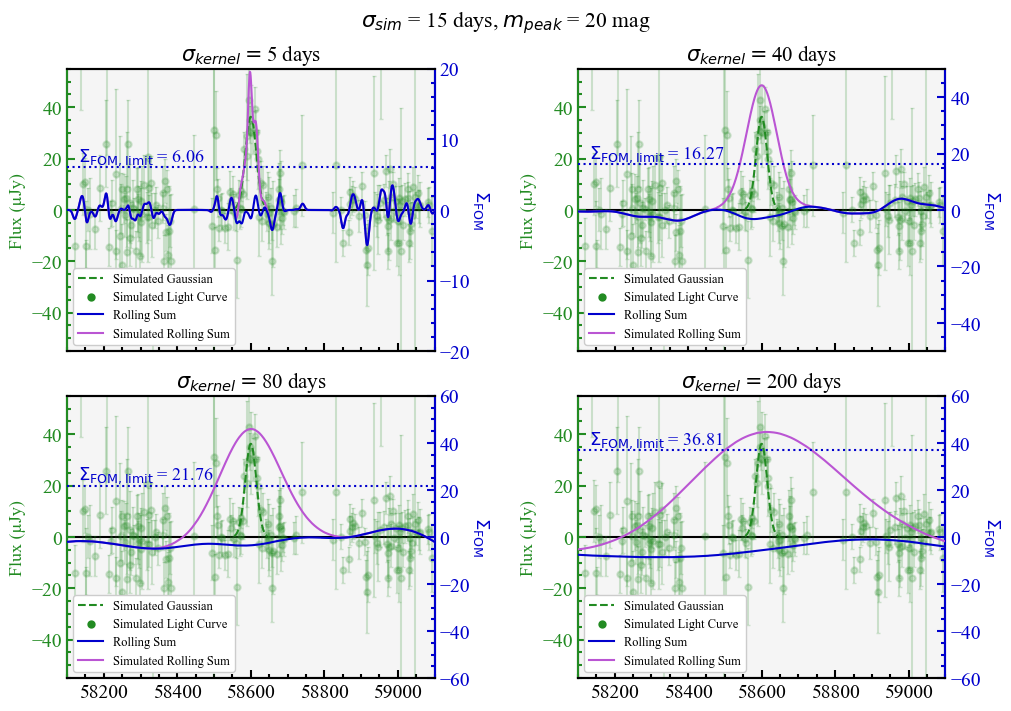

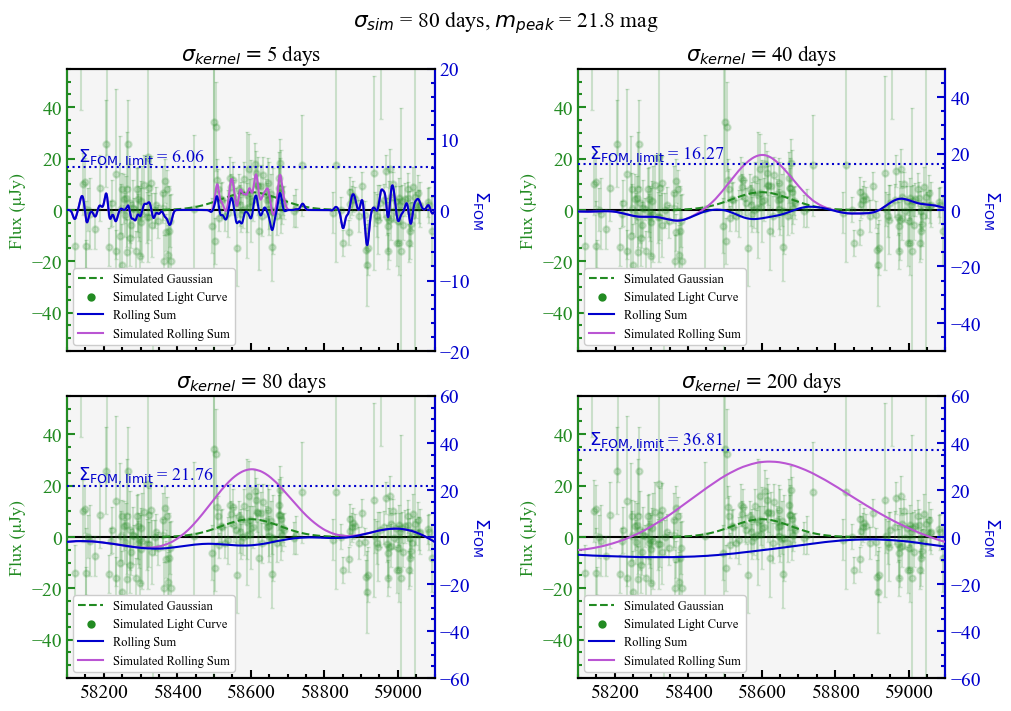

In [55]:
def plot_sim_bumps(lc, sigma_sim, sim_peak_mjd, sim_peak_mag, sigma_kerns, all_fom_limits, ylims_flux=None, ylims_fom=None, plot_gauss=True, save=False):
	fig, axes = plt.subplots(2, 2, gridspec_kw = {'wspace':0.06}, constrained_layout=True)
	fig.set_figwidth(10)
	fig.set_figheight(7)
	fig.suptitle(r'$\sigma_{sim}$ = '+f'{sigma_sim} days, '+r'$m_{peak}$ = '+f'{sim_peak_mag} mag')

	gaussian = Gaussian(sigma_sim, sim_peak_mag)

	for i, row in enumerate(axes):
		for j, ax1 in enumerate(row):
			idx = i*2 + j
			sigma_kern = sigma_kerns[idx]
			fom_limits = all_fom_limits[sigma_kern]
			lc.apply_rolling_sum(select_index, sigma_kern)
			sim_lc = lc.add_simulation(select_index, peak_mjd=sim_peak_mjd, gaussian=gaussian)
			
			flags_ = 0x0
			for k in flags: flags_ = flags_ | flags[k]

			ax2 = ax1.twinx()
			for ax in [ax1, ax2]:
				ax.set_facecolor(facecolor)
				ax.minorticks_on()
				ax.tick_params(direction='in', which='both')
				ax.set_xlim(sim_peak_mjd-500, sim_peak_mjd+500)
			
			ax1.set_title(r'$\sigma_{kernel} = $'+f'{sigma_kern} days')
			ax1.tick_params(axis='y', which='both', colors=select_ctrl_flux)
			ax1.set_ylim(-ylims_flux[idx], ylims_flux[idx])
			ax1.set_ylabel(r'Flux (µJy)', color=select_ctrl_flux)
			ax1.axhline(color='k', zorder=0)
			if i == 0: # top row
				ax1.set_xticklabels([])

			ax.tick_params(axis='y', which='both', colors=select_ctrl_fom)
			ax2.spines["right"].set_color(select_ctrl_fom)
			ax2.spines["left"].set_color(select_ctrl_flux)
			ax2.set_ylim(-ylims_fom[idx], ylims_fom[idx])
			ax2.set_ylabel(r'$\Sigma_{\rm FOM}$', color=select_ctrl_fom, rotation=270, labelpad=15)
			
			# simulated flux
			good_ix = sim_lc.ix_unmasked('Mask',maskval=flags_)
			ax1.errorbar(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJysim'], yerr=sim_lc.t.loc[good_ix,'duJy'], fmt='none', elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.2, zorder=10)
			ax1.scatter(sim_lc.t.loc[good_ix,'MJD'], sim_lc.t.loc[good_ix,'uJysim'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.2, zorder=10)

			# simulated gaussian flux
			if plot_gauss:
				def my_gauss(x, sigma=sigma_sim, h=mag2flux(sim_peak_mag), mid=sim_peak_mjd):
					variance = math.pow(sigma, 2)
					return h * math.exp(-math.pow(x-mid, 2)/(2*variance))
				x = np.linspace(sim_peak_mjd - 3*sigma_sim, sim_peak_mjd + 3*sigma_sim, 100)
				y = [my_gauss(xi) for xi in x]
				ax1.plot(x, y, color=select_ctrl_flux, linestyle=simbump_ls, linewidth=1.5, zorder=20)
				ax2.plot([0,1],[0,0], color=select_ctrl_flux, linestyle=simbump_ls, linewidth=1.5, alpha=1, label=f'Simulated Gaussian')
			ax2.scatter([0,1],[0,0], color=select_ctrl_flux, s=marker_size, lw=marker_edgewidth, alpha=1, marker='o', label=f'Simulated Light Curve')

			# fom
			ax2.plot(sim_lc.t['MJDbin'], sim_lc.t['SNRsumnorm'], color=select_ctrl_fom, linewidth=1.5, alpha=1, label=f'Rolling Sum', zorder=40)

			# fom limits
			for fom_limit in fom_limits:
				ax2.axhline(fom_limit, linewidth=1.5, color=select_ctrl_fom, linestyle=fomlimit_ls, zorder=50) 
				ax2.text(0.03, fom_limit, r'$\Sigma_{\rm FOM, limit}$ = '+str(fom_limit), color=select_ctrl_fom, transform=ax2.get_yaxis_transform(), ha="left", va="bottom") 


			# simulated fom 
			ax2.plot(sim_lc.t['MJDbin'], sim_lc.t['SNRsimsum'], color=sim_fom_color, linewidth=1.5, alpha=1, label=f'Simulated Rolling Sum', zorder=30)
			ax2.legend(loc='lower left', facecolor='white', framealpha=1.0).set_zorder(100)
	
	if save:
		save_plot(save_filename=f'simbumps_{sigma_sim}')

for i in range(len(sigma_sims)):
	plot_sim_bumps(lc, sigma_sims[i], sim_peak_mjds[i], sim_peak_mags[i], sigma_kerns[i], e.fom_limits, 
				   ylims_flux=ylims_flux[i], ylims_fom=ylims_fom[i], save=save)